# Time Series Traditional Analysis

## Import Libraries and Data


In [1]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from arch.unitroot import KPSS, PhillipsPerron, ZivotAndrews, VarianceRatio
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from typing import Tuple, List, Union
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    mean_absolute_percentage_error,
)
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Import data
merged_df = (
    pd.read_csv(
        "../data/merged_df.csv", parse_dates=["timestamp"], index_col="timestamp"
    )
    .sort_index()
    .convert_dtypes()
)
t_df = (
    pd.read_csv("../data/t.csv", parse_dates=["timestamp"], index_col="timestamp")
    .sort_index()
    .convert_dtypes()
)
v_df = (
    pd.read_csv("../data/v.csv", parse_dates=["timestamp"], index_col="timestamp")
    .sort_index()
    .convert_dtypes()
)

In [3]:
merged_df.head()

,close_t,close_v,t_diff,v_diff
timestamp,,,,
2019-01-02,29.54,56.02,0.0,0.0
2019-01-03,29.58,56.22,0.04,0.2
2019-01-04,30.34,56.36,0.76,0.14
2019-01-05,30.34,56.36,0.0,0.0
2019-01-06,30.34,56.36,0.0,0.0


In [4]:
# Create train-test split from the differenced data
forecast_window = 7
split_point = len(merged_df) - forecast_window

t_diff_train = merged_df["t_diff"].iloc[:split_point]
t_diff_test = merged_df["t_diff"].iloc[split_point:]
t_eval = merged_df["close_t"].iloc[split_point:]
v_diff_train = merged_df["v_diff"].iloc[:split_point]
v_diff_test = merged_df["v_diff"].iloc[split_point:]
v_eval = merged_df["close_v"].iloc[split_point:]

# Create a train-test split for the original data
t_close = merged_df.close_t.asfreq("D")
v_close = merged_df.close_v.asfreq("D")
t_arima_train = t_close.iloc[:split_point]
t_arima_test = t_close.iloc[split_point:]
v_arima_train = v_close.iloc[:split_point]
v_arima_test = v_close.iloc[split_point:]

# Let's check the lengths of the training and testing sets.
print(f"AT&T Training Set Length: {len(t_diff_train)}")
print(f"AT&T Test Set Length: {len(t_diff_test)}")
print(f"AT&T Evaluation Set Length: {len(t_eval)}")
print(f"Verizon Training Set Length: {len(v_diff_train)}")
print(f"Verizon Test Set Length: {len(v_diff_test)}")
print(f"Verizon Evaluation Set Length: {len(v_eval)}")

assert len(t_diff_train) == len(t_arima_train)

AT&T Training Set Length: 875
AT&T Test Set Length: 7
AT&T Evaluation Set Length: 7
Verizon Training Set Length: 875
Verizon Test Set Length: 7
Verizon Evaluation Set Length: 7


In [5]:
# Create baseline models: average and naive
baseline = pd.DataFrame(
    {
        "t_avg": [np.mean(t_arima_train[-forecast_window:])] * len(t_diff_test),
        "v_avg": [np.mean(v_arima_train[-forecast_window:])] * len(v_diff_test),
        "t_naive": t_arima_train[-forecast_window:].values,
        "v_naive": v_arima_train[-forecast_window:].values,
    },
    index=t_arima_test.index,
)

In [6]:
def evaluate_forecast(
    actual: Union[List[float], pd.Series], predicted: Union[List[float], pd.Series]
) -> Tuple[float, float, float]:
    """
    Evaluate forecast performance using RMSE, MAE, and MAPE metrics.

    Args:
        actual (List[float] or pd.Series): The actual observed values.
        predicted (List[float] or pd.Series): The predicted values.

    Returns:
        Tuple[float, float, float]: A tuple containing:
            - RMSE (Root Mean Squared Error)
            - MAE (Mean Absolute Error)
            - MAPE (Mean Absolute Percentage Error multiplied by 100)

    Raises:
        TypeError: If 'actual' or 'predicted' is not a list or pandas Series.
        ValueError: If the lengths of 'actual' and 'predicted' do not match.
        Exception: If an unexpected error occurs during metric calculations.
    """
    # Type checking
    if not isinstance(actual, (list, pd.Series)):
        raise TypeError(f"'actual' must be a list or pandas Series, got {type(actual)}")
    if not isinstance(predicted, (list, pd.Series)):
        raise TypeError(
            f"'predicted' must be a list or pandas Series, got {type(predicted)}"
        )

    # Length checking
    if len(actual) != len(predicted):
        raise ValueError("The length of 'actual' and 'predicted' must be the same.")

    try:
        rmse = root_mean_squared_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted) * 100
    except Exception as e:
        raise Exception(f"Error calculating forecast metrics: {e}")

    return rmse, mae, mape

In [7]:
def visualize_predictions(
    actual_t: Union[List[float], pd.Series],
    predictions_t: Union[List[float], pd.Series],
    actual_v: Union[List[float], pd.Series],
    predictions_v: Union[List[float], pd.Series],
    method: str,
    filename: str = None,
) -> None:
    """
    Visualize the actual vs. predicted stock prices for AT&T and Verizon.

    Args:
        actual_t (List[float] or pd.Series): Actual stock prices for AT&T.
        predictions_t (List[float] or pd.Series): Predicted stock prices for AT&T.
        actual_v (List[float] or pd.Series): Actual stock prices for Verizon.
        predictions_v (List[float] or pd.Series): Predicted stock prices for Verizon.
        method (str): The forecasting method used (e.g., 'ARIMA').
        filename (str): The filename to save the plot.

    Returns:
        None. Displays the plots.

    Raises:
        TypeError: If any of the actual or predicted inputs are not lists or pandas Series, or if 'method' is not a string.
        ValueError: If the lengths of actual and predicted series for either company do not match.
        Exception: If an unexpected error occurs during plotting.
    """
    # Type checking
    if not isinstance(actual_t, (list, pd.Series)):
        raise TypeError(
            f"'actual_t' must be a list or pandas Series, got {type(actual_t)}"
        )
    if not isinstance(predictions_t, (list, pd.Series)):
        raise TypeError(
            f"'predictions_t' must be a list or pandas Series, got {type(predictions_t)}"
        )
    if not isinstance(actual_v, (list, pd.Series)):
        raise TypeError(
            f"'actual_v' must be a list or pandas Series, got {type(actual_v)}"
        )
    if not isinstance(predictions_v, (list, pd.Series)):
        raise TypeError(
            f"'predictions_v' must be a list or pandas Series, got {type(predictions_v)}"
        )
    if not isinstance(method, str):
        raise TypeError(f"'method' must be a string, got {type(method)}")

    # Length checking
    len_t = len(actual_t)
    len_pred_t = len(predictions_t)
    len_v = len(actual_v)
    len_pred_v = len(predictions_v)

    if len_t != len_pred_t:
        raise ValueError("Length of 'actual_t' and 'predictions_t' must be the same.")
    if len_v != len_pred_v:
        raise ValueError("Length of 'actual_v' and 'predictions_v' must be the same.")

    try:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 10))

        # Plot for AT&T
        ax1.plot(actual_t, label="Actual", color="b")
        ax1.plot(
            predictions_t, label=f"Predictions ({method})", linestyle="-.", color="r"
        )
        ax1.set_title(f"AT&T Predicted Stock Price ({method})")
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Price ($)")
        ax1.legend(loc="best")

        # Plot for Verizon
        ax2.plot(actual_v, label="Actual", color="b")
        ax2.plot(
            predictions_v, label=f"Predictions ({method})", linestyle="-.", color="r"
        )
        ax2.set_title(f"Verizon Predicted Stock Price ({method})")
        ax2.set_xlabel("Date")
        ax2.set_ylabel("Price ($)")
        ax2.legend(loc="best")

        fig.autofmt_xdate()
        plt.show()
        if filename:
            fig.savefig(filename, bbox_inches="tight")
    except Exception as e:
        raise Exception(f"Error during visualization: {e}")

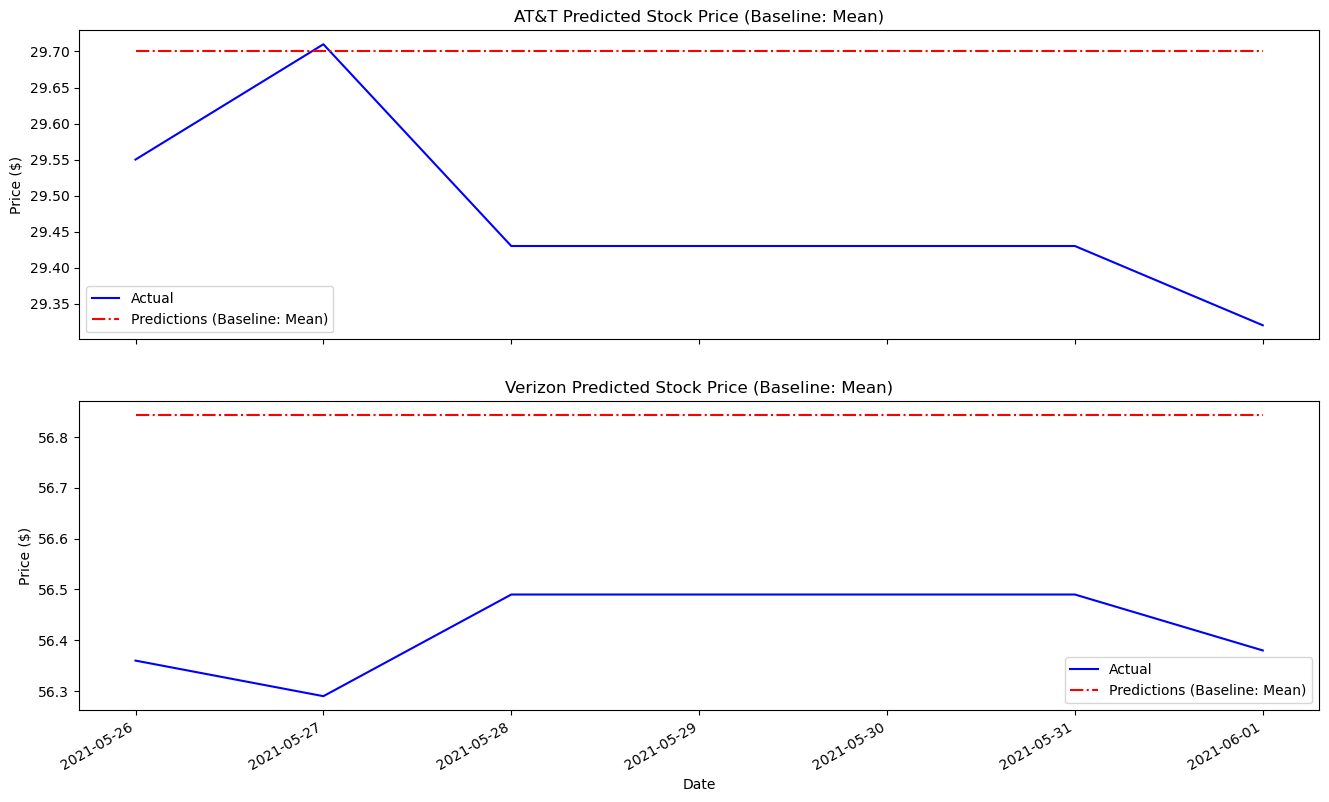

In [8]:
visualize_predictions(
    t_eval,
    baseline["t_avg"],
    v_eval,
    baseline["v_avg"],
    "Baseline: Mean",
    "../images/baseline_avg.png",
)

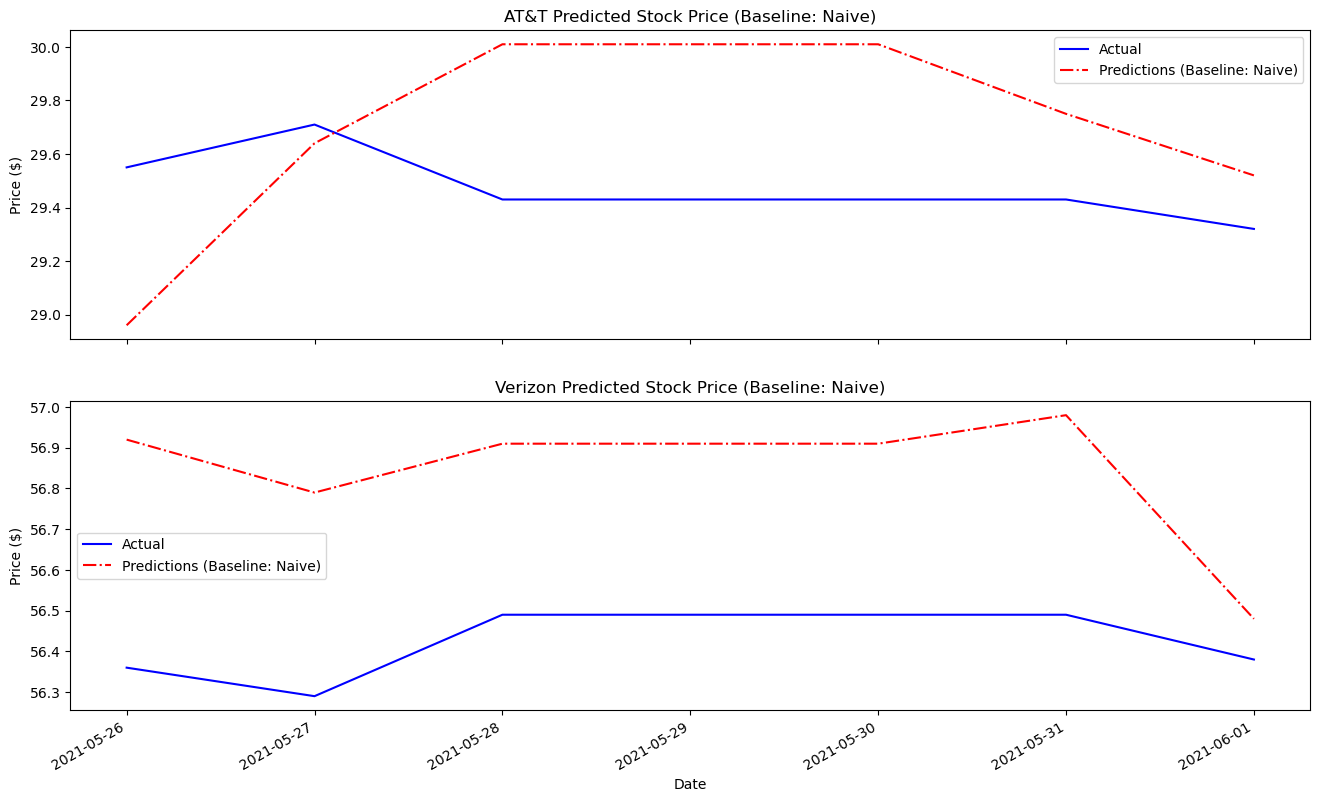

In [9]:
visualize_predictions(
    t_eval,
    baseline["t_naive"],
    v_eval,
    baseline["v_naive"],
    "Baseline: Naive",
    "../images/baseline_naive.png",
)

In [10]:
t_mean_rmse, t_mean_mae, t_mean_mape = evaluate_forecast(baseline["t_avg"], t_eval)
v_mean_rmse, v_mean_mae, v_mean_mape = evaluate_forecast(baseline["v_avg"], v_eval)
t_naive_rmse, t_naive_mae, t_naive_mape = evaluate_forecast(baseline["t_naive"], t_eval)
v_naive_rmse, v_naive_mae, v_naive_mape = evaluate_forecast(baseline["v_naive"], v_eval)

print(
    f"AT&T Mean - RMSE: {t_mean_rmse:.4f}, MAE: {t_mean_mae:.4f}, MAPE: {t_mean_mape:.2f}%"
)
print(
    f"Verizon Mean - RMSE: {v_mean_rmse:.4f}, MAE: {v_mean_mae:.4f}, MAPE: {v_mean_mape:.2f}%"
)
print(
    f"AT&T Naive - RMSE: {t_naive_rmse:.4f}, MAE: {t_naive_mae:.4f}, MAPE: {t_naive_mape:.2f}%"
)
print(
    f"Verizon Naive - RMSE: {v_naive_rmse:.4f}, MAE: {v_naive_mae:.4f}, MAPE: {v_naive_mape:.2f}%"
)

AT&T Mean - RMSE: 0.2560, MAE: 0.2314, MAPE: 0.78%
Verizon Mean - RMSE: 0.4228, MAE: 0.4157, MAPE: 0.73%
AT&T Naive - RMSE: 0.4636, MAE: 0.4171, MAPE: 1.40%
Verizon Naive - RMSE: 0.4380, MAE: 0.4157, MAPE: 0.73%


## Forecasting with Moving Average

We'll use the differenced series to model with moving average (MA) and exponential moving average.

We established in a previous notebook that the series is not stationary. We'll use the differenced series to model with moving average (MA) and exponential moving average.


In [11]:
def test_stationarity_robust(
    timeseries: Union[pd.Series, np.ndarray], alpha: float = 0.05
) -> None:
    """
    Perform robust stationarity tests on a time series.

    This function applies four different stationarity tests:
    1. Augmented Dickey-Fuller (ADF) test
    2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
    3. Phillips-Perron test
    4. Zivot-Andrews test (if the series has more than 100 observations)

    Args:
        timeseries (Union[pd.Series, np.ndarray]): The time series to test for stationarity.
        alpha (float, optional): Significance level for the tests. Default is 0.05.

    Raises:
        ValueError: If the input is not a pandas Series or numpy array.
        RuntimeError: If any of the statistical tests fail to run.

    Returns:
        None: Results are printed to the console.
    """
    if not isinstance(timeseries, (pd.Series, np.ndarray)):
        raise ValueError("Input must be a pandas Series or numpy array.")

    try:
        # ADF test
        ADF_result = adfuller(timeseries)
        print(f"ADF Statistic: {ADF_result[0]:.6f}")
        print(f"p-value: {ADF_result[1]:.6f}")
        if ADF_result[1] < alpha:
            print(
                "Reject the null hypothesis that there is a unit root. The time series may be stationary."
            )
        else:
            print(
                "Fail to reject the null hypothesis that there is a unit root. The time series is non-stationary."
            )

        # KPSS test (statsmodels implementation)
        KPSS_result = kpss(timeseries)
        print(f"\nKPSS Statistic (statsmodels): {KPSS_result[0]:.6f}")
        print(f"p-value: {KPSS_result[1]:.6f}")
        if KPSS_result[1] < alpha:
            print(
                "Reject the null hypothesis that the time series is stationary. The time series is non-stationary."
            )
        else:
            print(
                "Fail to reject the null hypothesis that the time series is stationary. The time series is stationary."
            )

        # KPSS test (arch implementation)
        kpss_arch_result = kpss(timeseries)

        # Display the results
        print(
            f"\nKPSS Statistic (arch): {kpss_arch_result[0]}"
        )  # This line gives me the error AttributeError: 'tuple' object has no attribute 'stat'
        print(f"P-Value: {kpss_arch_result[1]}")
        print("Critical Values:")
        for key, value in kpss_arch_result[3].items():
            print(f"   {key}: {value}")

        # Interpretation:
        if kpss_arch_result[1] < alpha:
            print("The series is likely non-stationary.")
        else:
            print("The series is likely stationary.")

        # Phillips-Perron test
        PP_result = PhillipsPerron(timeseries)
        print(f"\nPhillips-Perron Statistic: {PP_result.stat:.6f}")
        print(f"p-value: {PP_result.pvalue:.6f}")
        if PP_result.pvalue < alpha:
            print(
                "Reject the null hypothesis that there is a unit root. The time series may be stationary."
            )
        else:
            print(
                "Fail to reject the null hypothesis that there is a unit root. The time series is non-stationary."
            )

        # Zivot-Andrews test
        if len(timeseries) > 100:
            ZA_result = ZivotAndrews(timeseries)
            print(f"\nZivot-Andrews Statistic: {ZA_result.stat:.6f}")
            print(f"p-value: {ZA_result.pvalue:.6f}")
            if ZA_result.pvalue < alpha:
                print(
                    "Reject the null hypothesis that there is a unit root with a single structural break. The time series may be stationary."
                )
            else:
                print(
                    "Fail to reject the null hypothesis that there is a unit root with a single structural break. The time series is non-stationary."
                )
        else:
            print(
                "\nToo few observations to run the Zivot-Andrews test with trend c and 10 lags."
            )

        # Variance Ratio test
        VR_result = VarianceRatio(timeseries, lags=2)
        print(f"\nVariance Ratio statistic: {VR_result.stat:.4f}")
        print(f"P-value: {VR_result.pvalue:.4f}")
        if VR_result.pvalue < alpha:
            print(
                "Reject the null hypothesis of a random walk. The series is not a random walk per the Variance Ratio Test."
            )
        else:
            print(
                "Fail to reject the null hypothesis. The series may follow a random walk per the Variance Ratio Test."
            )

    except Exception as e:
        raise RuntimeError(f"An error occurred during the statistical tests: {str(e)}")

In [12]:
test_stationarity_robust(merged_df["t_diff"])

ADF Statistic: -7.654336
p-value: 0.000000
Reject the null hypothesis that there is a unit root. The time series may be stationary.

KPSS Statistic (statsmodels): 0.119698
p-value: 0.100000
Fail to reject the null hypothesis that the time series is stationary. The time series is stationary.

KPSS Statistic (arch): 0.11969808643186275
P-Value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The series is likely stationary.

Phillips-Perron Statistic: -33.161193
p-value: 0.000000
Reject the null hypothesis that there is a unit root. The time series may be stationary.

Zivot-Andrews Statistic: -8.011211
p-value: 0.000010
Reject the null hypothesis that there is a unit root with a single structural break. The time series may be stationary.

Variance Ratio statistic: -5.7310
P-value: 0.0000
Reject the null hypothesis of a random walk. The series is not a random walk per the Variance Ratio Test.


In [13]:
test_stationarity_robust(merged_df["v_diff"])

ADF Statistic: -7.428179
p-value: 0.000000
Reject the null hypothesis that there is a unit root. The time series may be stationary.

KPSS Statistic (statsmodels): 0.028200
p-value: 0.100000
Fail to reject the null hypothesis that the time series is stationary. The time series is stationary.

KPSS Statistic (arch): 0.028199647655779325
P-Value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The series is likely stationary.

Phillips-Perron Statistic: -34.365838
p-value: 0.000000
Reject the null hypothesis that there is a unit root. The time series may be stationary.

Zivot-Andrews Statistic: -7.758678
p-value: 0.000010
Reject the null hypothesis that there is a unit root with a single structural break. The time series may be stationary.

Variance Ratio statistic: -6.6542
P-value: 0.0000
Reject the null hypothesis of a random walk. The series is not a random walk per the Variance Ratio Test.


Next, we check the ACF plot to determine the order of the MA model.


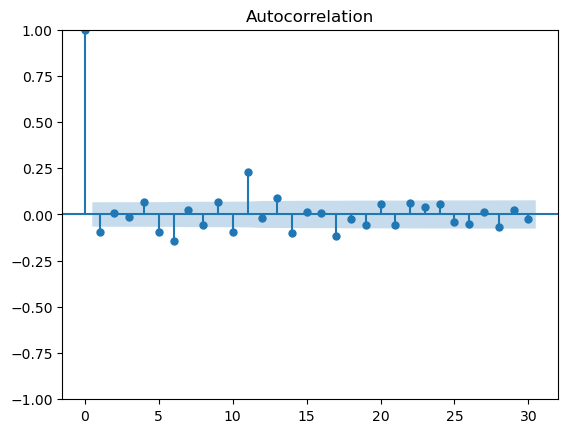

In [14]:
plot_acf(merged_df["t_diff"], lags=30)
plt.show()

If we're being charitable, this looks like a `MA(1)` model. The mildly significant spikes up to around lag 16 suggest that this is not a straightforward dataset. Let's check the Verizon differenced time series' ACF plot.


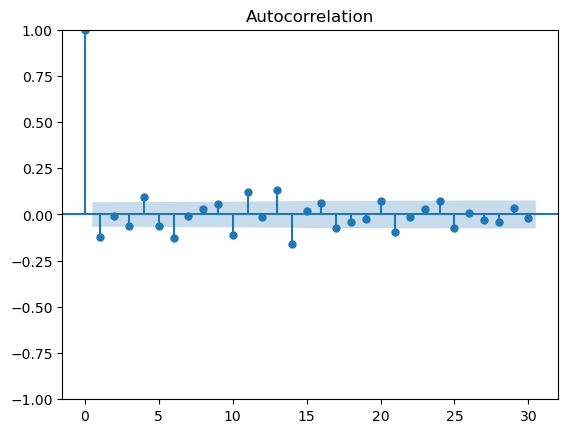

In [15]:
plot_acf(merged_df["v_diff"], lags=30)
plt.show()

The same pattern is observed in the Verizon series.


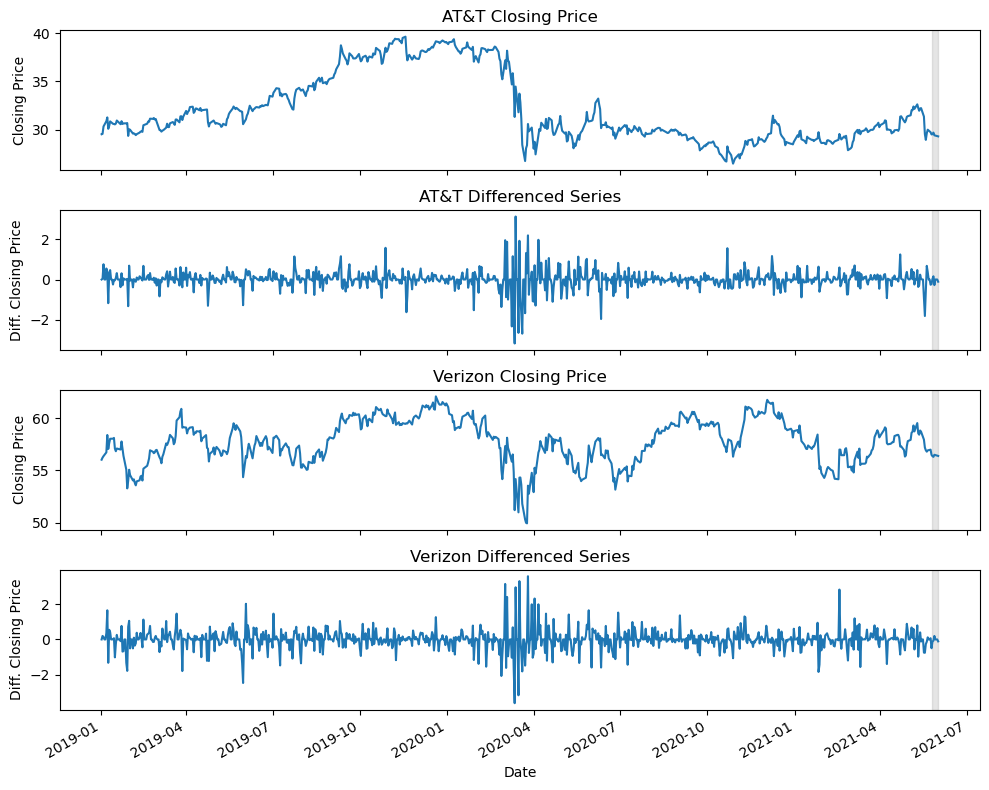

In [16]:
# Let's visualize the testing scenario for AT&T and Verizon.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(t_df.close, label="AT&T Closing Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Closing Price")
ax1.axvspan(
    merged_df["close_t"].index[split_point], t_df.index[-1], color="#808080", alpha=0.2
)
ax1.set_title("AT&T Closing Price")

ax2.plot(merged_df["t_diff"], label="AT&T Diff. Closing Price")
ax2.set_xlabel("Date")
ax2.set_ylabel("Diff. Closing Price")
ax2.axvspan(
    merged_df["t_diff"].index[split_point], t_df.index[-1], color="#808080", alpha=0.2
)
ax2.set_title("AT&T Differenced Series")

ax3.plot(v_df.close, label="Verizon Closing Price")
ax3.set_xlabel("Date")
ax3.set_ylabel("Closing Price")
ax3.axvspan(
    merged_df["close_v"].index[split_point], v_df.index[-1], color="#808080", alpha=0.2
)
ax3.set_title("Verizon Closing Price")

ax4.plot(merged_df["v_diff"], label="Verizon Diff. Closing Price")
ax4.set_xlabel("Date")
ax4.set_ylabel("Diff. Closing Price")
ax4.axvspan(
    merged_df["v_diff"].index[split_point], v_df.index[-1], color="#808080", alpha=0.2
)
ax4.set_title("Verizon Differenced Series")

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("../images/price_data.png", bbox_inches="tight")

In [17]:
def optimize_order(
    series: Union[List[float], pd.Series], model: str, max_order: int
) -> int:
    """
    Select the optimal number of lags for an AutoReg model based on AIC.

    Args:
        series (List[float] or pd.Series): The time series data.
        max_order (int): The maximum number of lags to consider.
        model (str): The type of model to fit ('ma' for moving average, 'ar' for autoregressive).

    Returns:
        int: The optimal number of lags with the lowest AIC.

    Raises:
        TypeError: If 'series' is not a list or pandas Series, or if 'max_order' is not an integer.
        ValueError: If 'max_order' is not positive or if no valid models could be fitted.
        Exception: If an unexpected error occurs during lag selection.
    """
    # Type checking
    if not isinstance(series, (list, pd.Series)):
        raise TypeError(f"'series' must be a list or pandas Series, got {type(series)}")
    if not isinstance(max_order, int):
        raise TypeError(f"'max_order' must be an integer, got {type(max_order)}")
    if max_order < 1:
        raise ValueError("'max_order' must be a positive integer.")

    try:
        aic_values = []
        if model == "ma":
            for order in range(1, max_order + 1):
                model = SARIMAX(series, order=(0, 0, order)).fit(disp=False)
                print(f"MA({order}) AIC: {model.aic}")
                aic_values.append((order, model.aic))
        elif model == "ar":
            for order in range(1, max_order + 1):
                model = SARIMAX(series, order=(order, 0, 0)).fit(disp=False)
                print(f"AR({order}) AIC: {model.aic}")
                aic_values.append((order, model.aic))
        else:
            raise ValueError("Invalid model type. Use 'ma' or 'ar'.")
        if not aic_values:
            raise ValueError("No valid models were fitted.")
        optimal_lag = min(aic_values, key=lambda x: x[1])[0]
    except Exception as e:
        raise Exception(f"Error selecting lag: {e}")

    return optimal_lag

In [18]:
optimal_order_t_ma = optimize_order(t_diff_train, "ma", max_order=28)
optimal_order_v_ma = optimize_order(v_diff_train, "ma", max_order=28)

MA(1) AIC: 1108.3412173476358
MA(2) AIC: 1110.3202233808915
MA(3) AIC: 1112.3080095394812
MA(4) AIC: 1111.9434910661305
MA(5) AIC: 1098.691392708987
MA(6) AIC: 1092.676098204171
MA(7) AIC: 1094.6712734367159
MA(8) AIC: 1092.2420494296957
MA(9) AIC: 1092.7842816561556
MA(10) AIC: 1092.3744245889318
MA(11) AIC: 1058.883876634974
MA(12) AIC: 1059.7126402294343
MA(13) AIC: 1059.8072536117825
MA(14) AIC: 1056.530428645683
MA(15) AIC: 1058.0387259465085
MA(16) AIC: 1059.8925231846295
MA(17) AIC: 1053.9469022761223
MA(18) AIC: 1054.8101751942254
MA(19) AIC: 1054.9581054430741
MA(20) AIC: 1056.4823108702294
MA(21) AIC: 1056.5479934604205
MA(22) AIC: 1054.3406080853244
MA(23) AIC: 1054.7788565624098
MA(24) AIC: 1051.6417758823209
MA(25) AIC: 1047.1424313576138
MA(26) AIC: 1047.726820154848
MA(27) AIC: 1049.4068450182967
MA(28) AIC: 1049.9351258722925
MA(1) AIC: 1560.0933041998148
MA(2) AIC: 1561.7009991626867
MA(3) AIC: 1561.2119053635683
MA(4) AIC: 1558.857483212411
MA(5) AIC: 1552.60877045315

In [19]:
print(f"Optimal MA order for AT&T: {optimal_order_t_ma}")
print(f"Optimal MA order for Verizon: {optimal_order_v_ma}")

Optimal MA order for AT&T: 25
Optimal MA order for Verizon: 27


In [20]:
t_ma = ARIMA(t_diff_train, order=(0, 0, 1))
v_ma = ARIMA(v_diff_train, order=(0, 0, 1))
t_ma_opt = ARIMA(t_diff_train, order=(0, 0, optimal_order_t_ma))
v_ma_opt = ARIMA(v_diff_train, order=(0, 0, optimal_order_v_ma))

In [21]:
t_ma_predictions = t_ma.fit().forecast(forecast_window)
v_ma_predictions = v_ma.fit().forecast(forecast_window)
t_ma_opt_predictions = t_ma_opt.fit().forecast(forecast_window)
v_ma_opt_predictions = v_ma_opt.fit().forecast(forecast_window)

In [22]:
ma_predictions = pd.concat(
    [t_ma_predictions, v_ma_predictions], keys=["t_ma", "v_ma"], axis=1
)
ma_predictions["t_inv_diff"] = (
    merged_df["close_t"].iloc[split_point] + ma_predictions["t_ma"].cumsum()
)
ma_predictions["v_inv_diff"] = (
    merged_df["close_v"].iloc[split_point] + ma_predictions["v_ma"].cumsum()
)
ma_predictions_opt = pd.concat(
    [t_ma_opt_predictions, v_ma_opt_predictions], keys=["t_ma", "v_ma"], axis=1
)
ma_predictions_opt["t_inv_diff"] = (
    merged_df["close_t"].iloc[split_point] + ma_predictions_opt["t_ma"].cumsum()
)
ma_predictions_opt["v_inv_diff"] = (
    merged_df["close_v"].iloc[split_point] + ma_predictions_opt["v_ma"].cumsum()
)

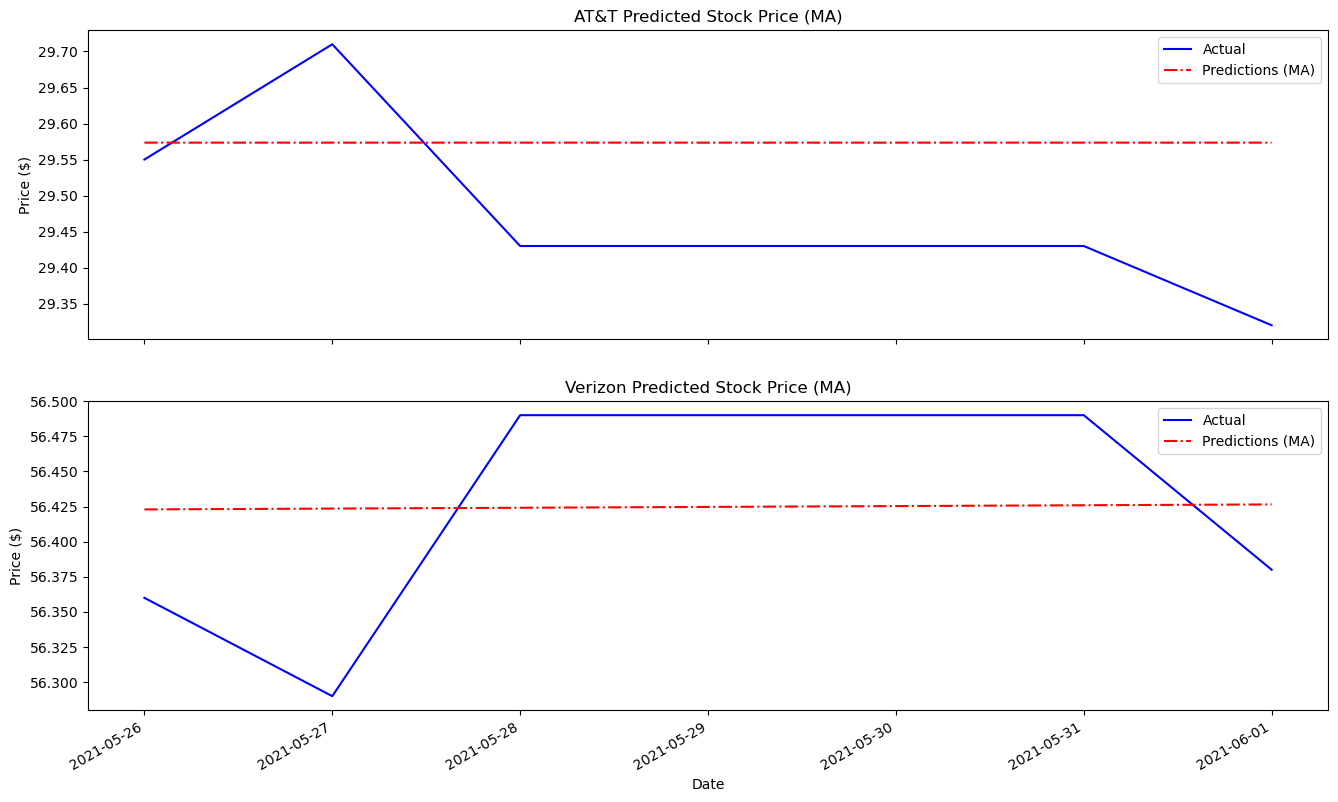

In [23]:
visualize_predictions(
    t_eval,
    ma_predictions["t_inv_diff"],
    v_eval,
    ma_predictions["v_inv_diff"],
    "MA",
    "../images/ma_predictions.png",
)

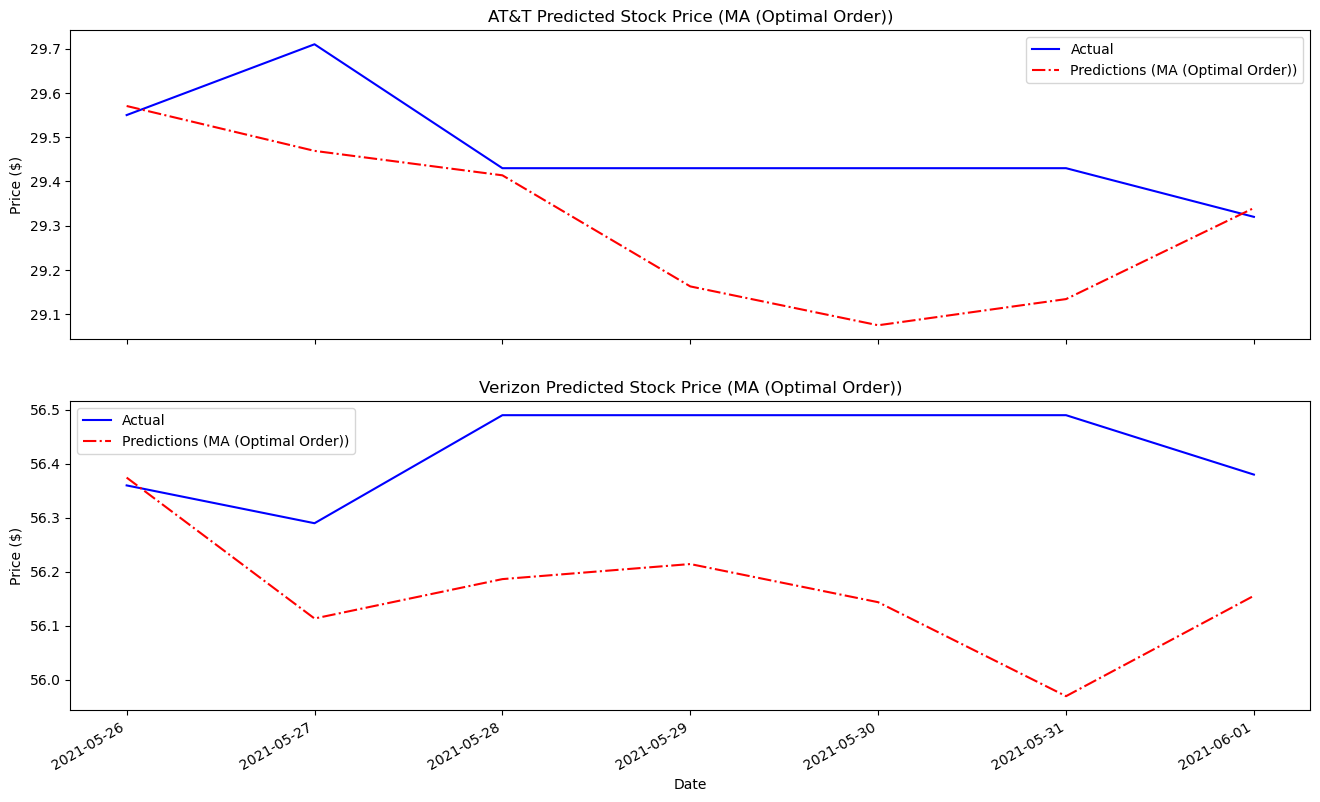

In [24]:
visualize_predictions(
    t_eval,
    ma_predictions_opt["t_inv_diff"],
    v_eval,
    ma_predictions_opt["v_inv_diff"],
    "MA (Optimal Order)",
    "../images/ma_optimal_predictions.png",
)

In [25]:
t_ma_rmse, t_ma_mae, t_ma_mape = evaluate_forecast(t_eval, ma_predictions["t_inv_diff"])
v_ma_rmse, v_ma_mae, v_ma_mape = evaluate_forecast(v_eval, ma_predictions["v_inv_diff"])

print(
    f"AT&T MA(1) - RMSE: {t_ma_rmse:.4f}, MAE: {t_ma_mae:.4f}, MAPE: {t_ma_mape:.2f}%"
)
print(
    f"Verizon MA(1) - RMSE: {v_ma_rmse:.4f}, MAE: {v_ma_mae:.4f}, MAPE: {v_ma_mape:.2f}%"
)

AT&T MA(1) - RMSE: 0.1539, MAE: 0.1410, MAPE: 0.48%
Verizon MA(1) - RMSE: 0.0764, MAE: 0.0718, MAPE: 0.13%


In [26]:
t_ma_opt_rmse, t_ma_opt_mae, t_ma_opt_mape = evaluate_forecast(
    t_eval, ma_predictions_opt["t_inv_diff"]
)
v_ma_opt_rmse, v_ma_opt_mae, v_ma_opt_mape = evaluate_forecast(
    v_eval, ma_predictions_opt["v_inv_diff"]
)
print(
    f"AT&T MA({optimal_order_t_ma}) - RMSE: {t_ma_opt_rmse:.4f}, MAE: {t_ma_opt_mae:.4f}, MAPE: {t_ma_opt_mape:.2f}%"
)
print(
    f"Verizon MA({optimal_order_v_ma}) - RMSE: {v_ma_opt_rmse:.4f}, MAE: {v_ma_opt_mae:.4f}, MAPE: {v_ma_opt_mape:.2f}%"
)

AT&T MA(25) - RMSE: 0.2217, MAE: 0.1736, MAPE: 0.59%
Verizon MA(27) - RMSE: 0.3024, MAE: 0.2658, MAPE: 0.47%


## Modeling with EWM

We'll use the differenced series to model with exponential moving average.


In [27]:
# Calculate the exponential weighted average
merged_df = merged_df.assign(
    t_ewm_short=merged_df.close_t.ewm(span=6, adjust=False).mean()
)
merged_df = merged_df.assign(
    t_ewm_long=merged_df.close_t.ewm(span=11, adjust=False).mean()
)
merged_df = merged_df.assign(
    v_ewm_short=merged_df.close_v.ewm(span=4, adjust=False).mean()
)
merged_df = merged_df.assign(
    v_ewm_long=merged_df.close_v.ewm(span=11, adjust=False).mean()
)

In [28]:
print(
    f"AT&T Short-Window EWM RMSE: {root_mean_squared_error(merged_df.close_t, merged_df.t_ewm_short):.4f}"
)
print(
    f"AT&T Long-Window EWM RMSE: {root_mean_squared_error(merged_df.close_t, merged_df.t_ewm_long):.4f}"
)
print(
    f"Verizon Short-Window EWM RMSE: {root_mean_squared_error(merged_df.close_v, merged_df.v_ewm_short):.4f}"
)
print(
    f"Verizon Long-Window EWM RMSE: {root_mean_squared_error(merged_df.close_v, merged_df.v_ewm_long):.4f}"
)

AT&T Short-Window EWM RMSE: 0.4236
AT&T Long-Window EWM RMSE: 0.5979
Verizon Short-Window EWM RMSE: 0.4031
Verizon Long-Window EWM RMSE: 0.7434


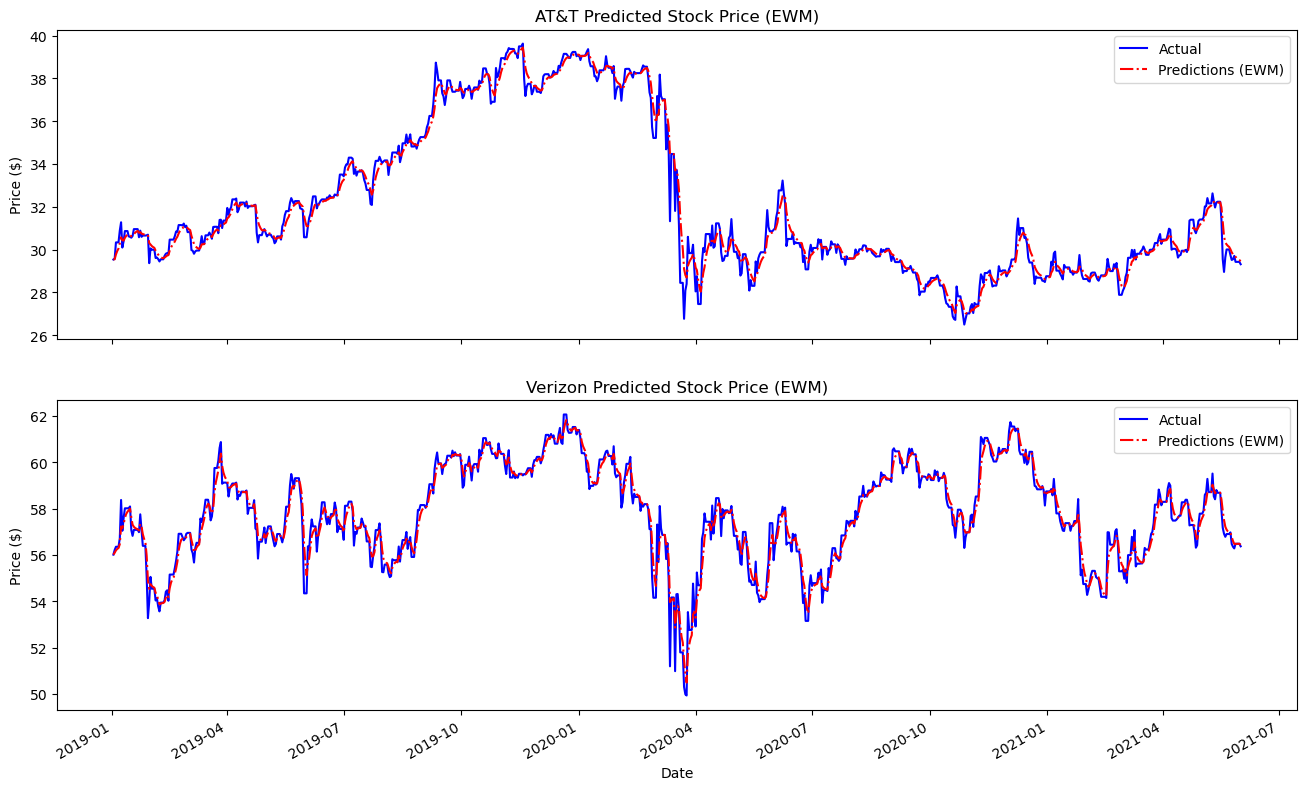

In [29]:
visualize_predictions(
    merged_df.close_t,
    merged_df.t_ewm_short,
    merged_df.close_v,
    merged_df.v_ewm_short,
    "EWM",
)

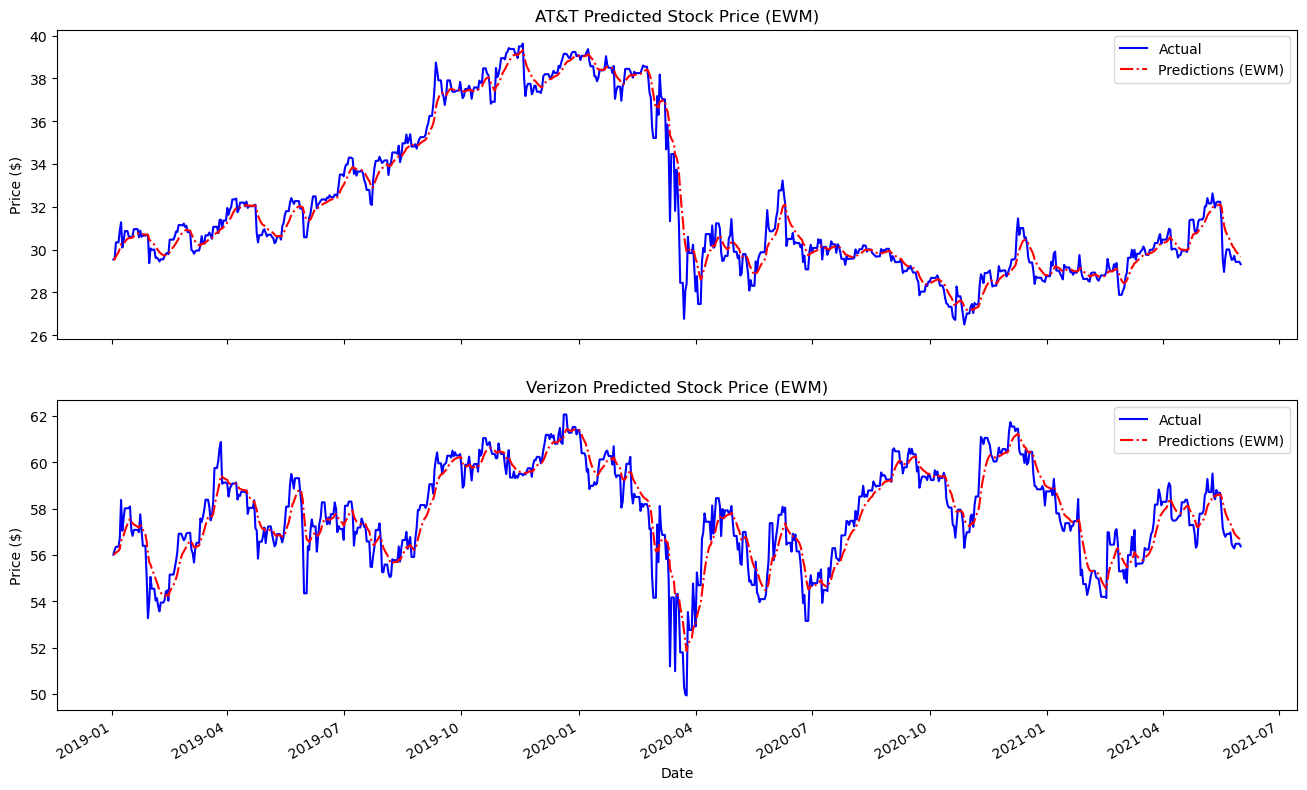

In [30]:
visualize_predictions(
    merged_df.close_t,
    merged_df.t_ewm_long,
    merged_df.close_v,
    merged_df.v_ewm_long,
    "EWM",
)

## Forecasting with Autoregressive


In [31]:
# Separating the differenced time series off into their own DataFrames for convenience
t_diff = merged_df.t_diff.asfreq("D")
v_diff = merged_df.v_diff.asfreq("D")

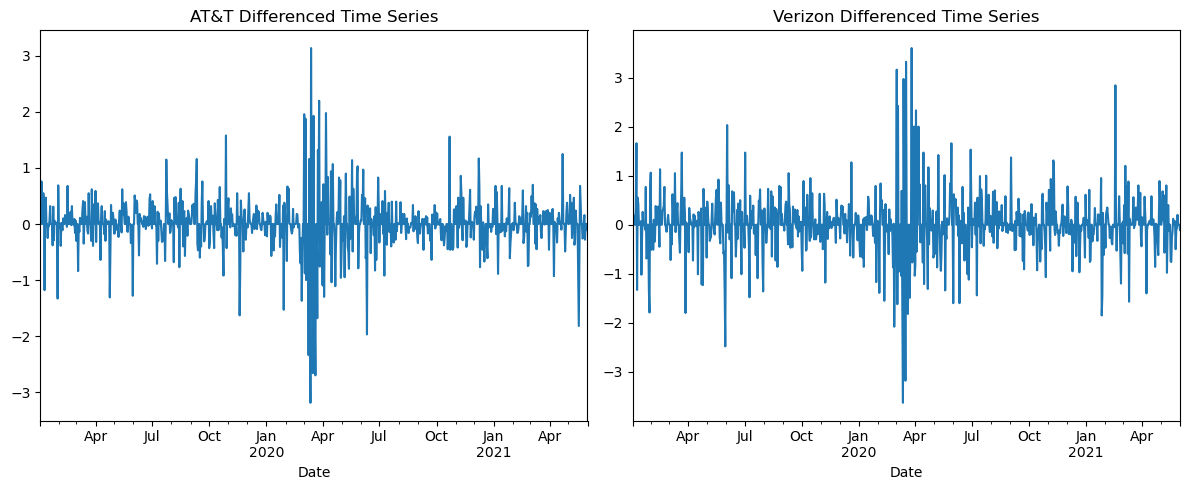

<Figure size 640x480 with 0 Axes>

In [32]:
# Let's look at the differenced data.
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF for AT&T Differenced Series
t_diff.plot(title="AT&T Differenced Time Series", ax=ax[0])
ax[0].set_xlabel("Date")

# Plot ACF for Verizon Differenced Series
v_diff.plot(title="Verizon Differenced Time Series", ax=ax[1])
ax[1].set_xlabel("Date")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()
plt.savefig("../images/att_v_differenced_series.png")

Both datasets have ADF p-values << 0.05, so we can reject the null hypothesis and conclude that both datasets are stationary. Let's plot the ACF again to see whether there is autocorrelation.


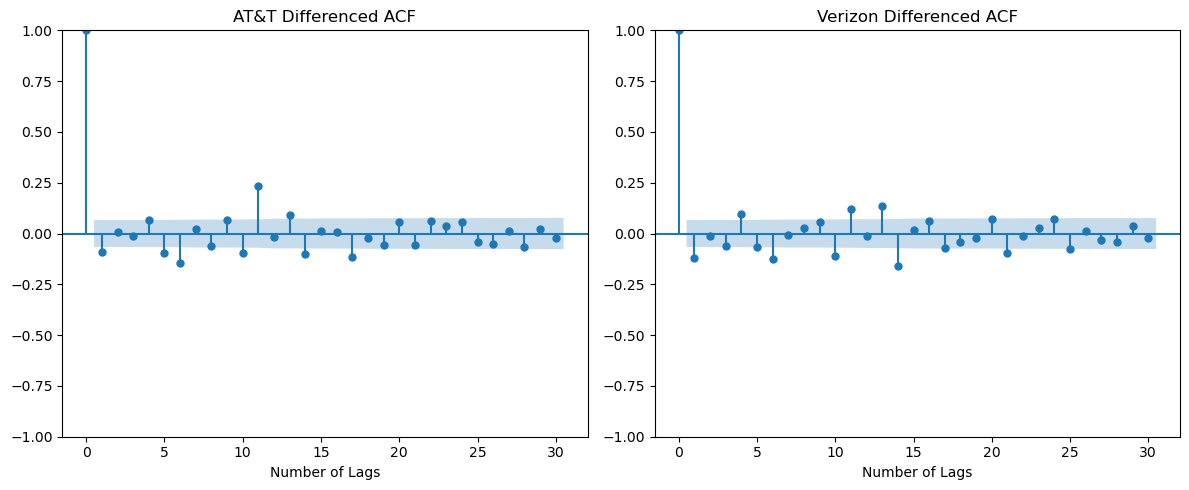

In [33]:
# Plot ACF for the differenced time series
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF for AT&T Differenced Series
plot_acf(t_diff, lags=30, title="AT&T Differenced ACF", ax=ax[0])
ax[0].set_xlabel("Number of Lags")

# Plot ACF for Verizon Differenced Series
plot_acf(v_diff, lags=30, title="Verizon Differenced ACF", ax=ax[1])
ax[1].set_xlabel("Number of Lags")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()
fig.savefig("../images/att_v_diff_acf.png")

A gradually decreasing ACF plot would suggest an autoregressive model. This isn't exactly the case, but it looks like there isn't a clear MA(q) model either. Let's plot the PACF to see if we can determine the order of the AR model.


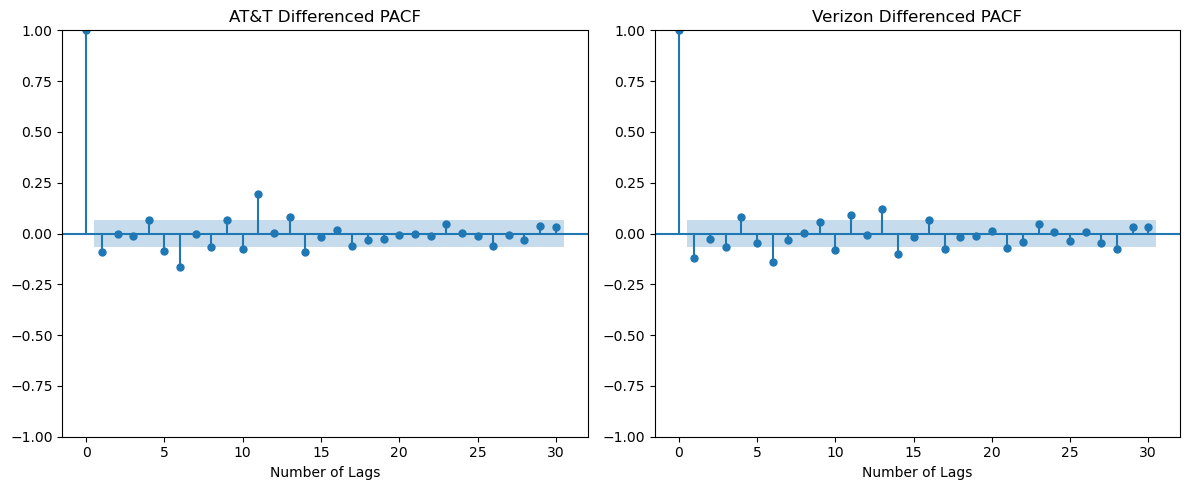

In [34]:
# Plot PACF for the differenced time series
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF for AT&T Differenced Series
plot_pacf(t_diff, lags=30, title="AT&T Differenced PACF", ax=ax[0])
ax[0].set_xlabel("Number of Lags")

# Plot ACF for Verizon Differenced Series
plot_pacf(v_diff, lags=30, title="Verizon Differenced PACF", ax=ax[1])
ax[1].set_xlabel("Number of Lags")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()
fig.savefig("../images/att_v_pacf.png")

This looks like an `AR(1)` model for both datasets, though there appears to be some seasonality in both plots. We can look at ARIMA or SARIMA models later to account for this. In the meantime, let's split the data into training and testing sets.


In [35]:
def select_lag(series: Union[List[float], pd.Series], max_lag: int) -> int:
    """
    Select the optimal number of lags for an AutoReg model based on AIC.

    Args:
        series (List[float] or pd.Series): The time series data.
        max_lag (int): The maximum number of lags to consider.

    Returns:
        int: The optimal number of lags with the lowest AIC.

    Raises:
        TypeError: If 'series' is not a list or pandas Series, or if 'max_lag' is not an integer.
        ValueError: If 'max_lag' is not positive or if no valid models could be fitted.
        Exception: If an unexpected error occurs during lag selection.
    """
    # Type checking
    if not isinstance(series, (list, pd.Series)):
        raise TypeError(f"'series' must be a list or pandas Series, got {type(series)}")
    if not isinstance(max_lag, int):
        raise TypeError(f"'max_lag' must be an integer, got {type(max_lag)}")
    if max_lag < 1:
        raise ValueError("'max_lag' must be a positive integer.")

    try:
        aic_values = []
        for lag in range(1, max_lag + 1):
            model = AutoReg(series, lags=lag).fit()
            aic_values.append((lag, model.aic))
        if not aic_values:
            raise ValueError("No valid models were fitted.")
        optimal_lag = min(aic_values, key=lambda x: x[1])[0]
    except Exception as e:
        raise Exception(f"Error selecting lag: {e}")

    return optimal_lag

In [36]:
optimal_lag_t = select_lag(t_diff_train, max_lag=21)
optimal_lag_v = select_lag(v_diff_train, max_lag=21)

print(f"Optimal AT&T Lag: {optimal_lag_t}")
print(f"Optimal Verizon Lag: {optimal_lag_v}")

t_ar = AutoReg(t_diff_train, lags=optimal_lag_t).fit()
v_ar = AutoReg(v_diff_train, lags=optimal_lag_v).fit()
t_ar_ord2 = AutoReg(t_diff_train, lags=2).fit()
v_ar_ord2 = AutoReg(v_diff_train, lags=2).fit()

Optimal AT&T Lag: 14
Optimal Verizon Lag: 21


In [37]:
t_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 t_diff   No. Observations:                  875
Model:                    AutoReg(14)   Log Likelihood                -496.508
Method:               Conditional MLE   S.D. of innovations              0.431
Date:                Thu, 08 May 2025   AIC                           1025.016
Time:                        14:29:57   BIC                           1101.146
Sample:                    01-16-2019   HQIC                          1054.160
                         - 05-25-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.015     -0.131      0.896      -0.031       0.027
t_diff.L1     -0.0698      0.034     -2.056      0.040      -0.136      -0.003
t_diff.L2     -0.0309      0.034     -0.910      0.363      -0.097       0.036
t_diff.L3      0.0276      0.034      0.812      0.417      -0.039       0.094
t_diff.L4      0.0447      0.033      1.343      0.179      -0.021       0.110
t_diff.L5     -0.0657      0.033     -1.974      0.048      -0.131      -0.000
t_diff.L6     -0.1393      0.033     -4.179      0.000      -0.205      -0.074
t_diff.L7     -0.0117      0.034     -0.350      0.726      -0.078       0.054
t_diff.L8     -0.0628      0.034     -1.847      0.065      -0.129       0.004
t_diff.L9      0.0501      0.034      1.486      0.137      -0.016       0.116
t_diff.L10    -0.0501      0.034     -1.485      0.138      -0.116       0.016
t_diff.L11     0.2055      0.034      6.100      0.000       0.139       0.272
t_diff.L12     0.0127      0.034      0.371      0.711      -0.055       0.080
t_diff.L13     0.0745      0.034      2.171      0.030       0.007       0.142
t_diff.L14    -0.0955      0.034     -2.783      0.005      -0.163      -0.028
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0235           -0.2964j            1.0656           -0.4551
AR.2            -1.0235           +0.2964j            1.0656            0.4551
AR.3            -0.8622           -0.8153j            1.1866           -0.3795
AR.4            -0.8622           +0.8153j            1.1866            0.3795
AR.5            -0.5211           -1.1454j            1.2584           -0.3180
AR.6            -0.5211           +1.1454j            1.2584            0.3180
AR.7            -0.0522           -1.1288j            1.1300           -0.2574
AR.8            -0.0522           +1.1288j            1.1300            0.2574
AR.9             0.4986           -1.0382j            1.1518           -0.1787
AR.10            0.4986           +1.0382j            1.1518            0.1787
AR.11            0.9323           -0.5919j            1.1043           -0.0900
AR.12            0.9323           +0.5919j            1.1043            0.0900
AR.13            1.3186           -0.0000j            1.3186           -0.0000
AR.14            1.5183           -0.0000j            1.5183           -0.0000
------------------------------------------------------------------------------
"""

In [38]:
v_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 v_diff   No. Observations:                  875
Model:                    AutoReg(21)   Log Likelihood                -718.969
Method:               Conditional MLE   S.D. of innovations              0.562
Date:                Thu, 08 May 2025   AIC                           1483.937
Time:                        14:29:57   BIC                           1593.186
Sample:                    01-23-2019   HQIC                          1525.776
                         - 05-25-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.019     -0.024      0.981      -0.038       0.037
v_diff.L1     -0.0903      0.034     -2.644      0.008      -0.157      -0.023
v_diff.L2     -0.0270      0.034     -0.787      0.431      -0.094       0.040
v_diff.L3     -0.0584      0.034     -1.702      0.089      -0.126       0.009
v_diff.L4      0.0543      0.034      1.581      0.114      -0.013       0.122
v_diff.L5     -0.0616      0.034     -1.797      0.072      -0.129       0.006
v_diff.L6     -0.1071      0.034     -3.121      0.002      -0.174      -0.040
v_diff.L7     -0.0442      0.034     -1.284      0.199      -0.112       0.023
v_diff.L8      0.0234      0.034      0.683      0.494      -0.044       0.091
v_diff.L9      0.0357      0.034      1.045      0.296      -0.031       0.103
v_diff.L10    -0.0495      0.034     -1.448      0.148      -0.116       0.017
v_diff.L11     0.0849      0.034      2.492      0.013       0.018       0.152
v_diff.L12    -0.0086      0.034     -0.252      0.801      -0.076       0.058
v_diff.L13     0.1171      0.034      3.430      0.001       0.050       0.184
v_diff.L14    -0.1058      0.034     -3.083      0.002      -0.173      -0.039
v_diff.L15    -0.0236      0.034     -0.687      0.492      -0.091       0.044
v_diff.L16     0.0555      0.034      1.626      0.104      -0.011       0.123
v_diff.L17    -0.0748      0.034     -2.191      0.028      -0.142      -0.008
v_diff.L18    -0.0206      0.034     -0.602      0.547      -0.088       0.046
v_diff.L19    -0.0103      0.034     -0.301      0.763      -0.077       0.057
v_diff.L20     0.0038      0.034      0.110      0.912      -0.063       0.071
v_diff.L21    -0.0729      0.034     -2.144      0.032      -0.140      -0.006
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0138           -0.2994j            1.0571           -0.4543
AR.2            -1.0138           +0.2994j            1.0571            0.4543
AR.3            -1.1532           -0.0000j            1.1532           -0.5000
AR.4            -0.8934           -0.7676j            1.1778           -0.3870
AR.5            -0.8934           +0.7676j            1.1778            0.3870
AR.6            -0.8341           -0.8398j            1.1836           -0.3745
AR.7            -0.8341           +0.8398j            1.1836            0.3745
AR.8            -0.4155           -1.0072j            1.0895           -0.3123
AR.9            -0.4155           +1.0072j            1.0895            0.3123
AR.10           -0.0276           -1.0691j            1.0694           -0.2541
AR.11           -0.0276           +1.0691j            1.0694            0.2541
AR.12            1.1083           -0.1807j            1.1229           -0.0257
AR

In [39]:
t_predictions = t_ar.forecast(forecast_window)
v_predictions = v_ar.forecast(forecast_window)
t_predictions_ord2 = t_ar_ord2.forecast(forecast_window)
v_predictions_ord2 = v_ar_ord2.forecast(forecast_window)

In [40]:
ar_predictions = pd.concat(
    [t_predictions, v_predictions], keys=["t_ar", "v_ar"], axis=1
)
ar_predictions["t_inv_diff"] = (
    merged_df["close_t"].iloc[split_point] + ar_predictions["t_ar"].cumsum()
)
ar_predictions["v_inv_diff"] = (
    merged_df["close_v"].iloc[split_point] + ar_predictions["v_ar"].cumsum()
)

ar_predictions_ord2 = pd.concat(
    [t_predictions_ord2, v_predictions_ord2], keys=["t_ar", "v_ar"], axis=1
)
ar_predictions_ord2["t_inv_diff"] = (
    merged_df["close_t"].iloc[split_point] + ar_predictions_ord2["t_ar"].cumsum()
)
ar_predictions_ord2["v_inv_diff"] = (
    merged_df["close_v"].iloc[split_point] + ar_predictions_ord2["v_ar"].cumsum()
)

In [41]:
t_ar_rmse, t_ar_mae, t_ar_mape = evaluate_forecast(t_eval, ar_predictions["t_inv_diff"])
v_ar_rmse, v_ar_mae, v_ar_mape = evaluate_forecast(v_eval, ar_predictions["v_inv_diff"])

print(
    f"AT&T AR({optimal_lag_t}) - RMSE: {t_ar_rmse:.4f}, MAE: {t_ar_mae:.4f}, MAPE: {t_ar_mape:.2f}%"
)
print(
    f"Verizon AR({optimal_lag_v}) - RMSE: {v_ar_rmse:.4f}, MAE: {v_ar_mae:.4f}, MAPE: {v_ar_mape:.2f}%"
)

AT&T AR(14) - RMSE: 0.3615, MAE: 0.3015, MAPE: 1.02%
Verizon AR(21) - RMSE: 0.1585, MAE: 0.1308, MAPE: 0.23%


In [42]:
t_ar_ord2_rmse, t_ar_ord2_mae, t_ar_ord2_mape = evaluate_forecast(
    t_eval, ar_predictions_ord2["t_inv_diff"]
)
v_ar_ord2_rmse, v_ar_ord2_mae, v_ar_ord2_mape = evaluate_forecast(
    v_eval, ar_predictions_ord2["v_inv_diff"]
)
print(
    f"AT&T AR(2) - RMSE: {t_ar_ord2_rmse:.4f}, MAE: {t_ar_ord2_mae:.4f}, MAPE: {t_ar_ord2_mape:.2f}%"
)
print(
    f"Verizon AR(2) - RMSE: {v_ar_ord2_rmse:.4f}, MAE: {v_ar_ord2_mae:.4f}, MAPE: {v_ar_ord2_mape:.2f}%"
)

AT&T AR(2) - RMSE: 0.1519, MAE: 0.1391, MAPE: 0.47%
Verizon AR(2) - RMSE: 0.0767, MAE: 0.0718, MAPE: 0.13%


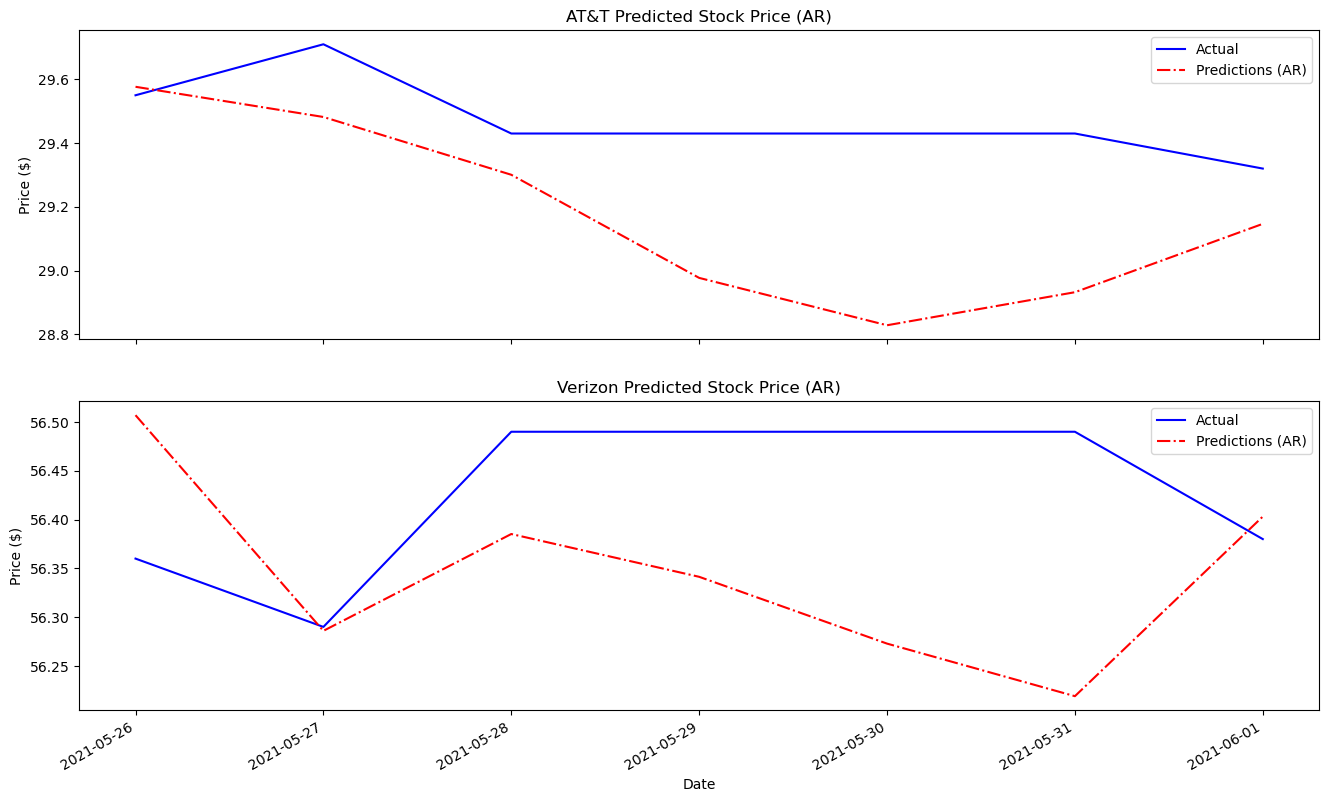

In [43]:
visualize_predictions(
    t_eval,
    ar_predictions["t_inv_diff"],
    v_eval,
    ar_predictions["v_inv_diff"],
    "AR",
    "../images/ar_predictions.png",
)

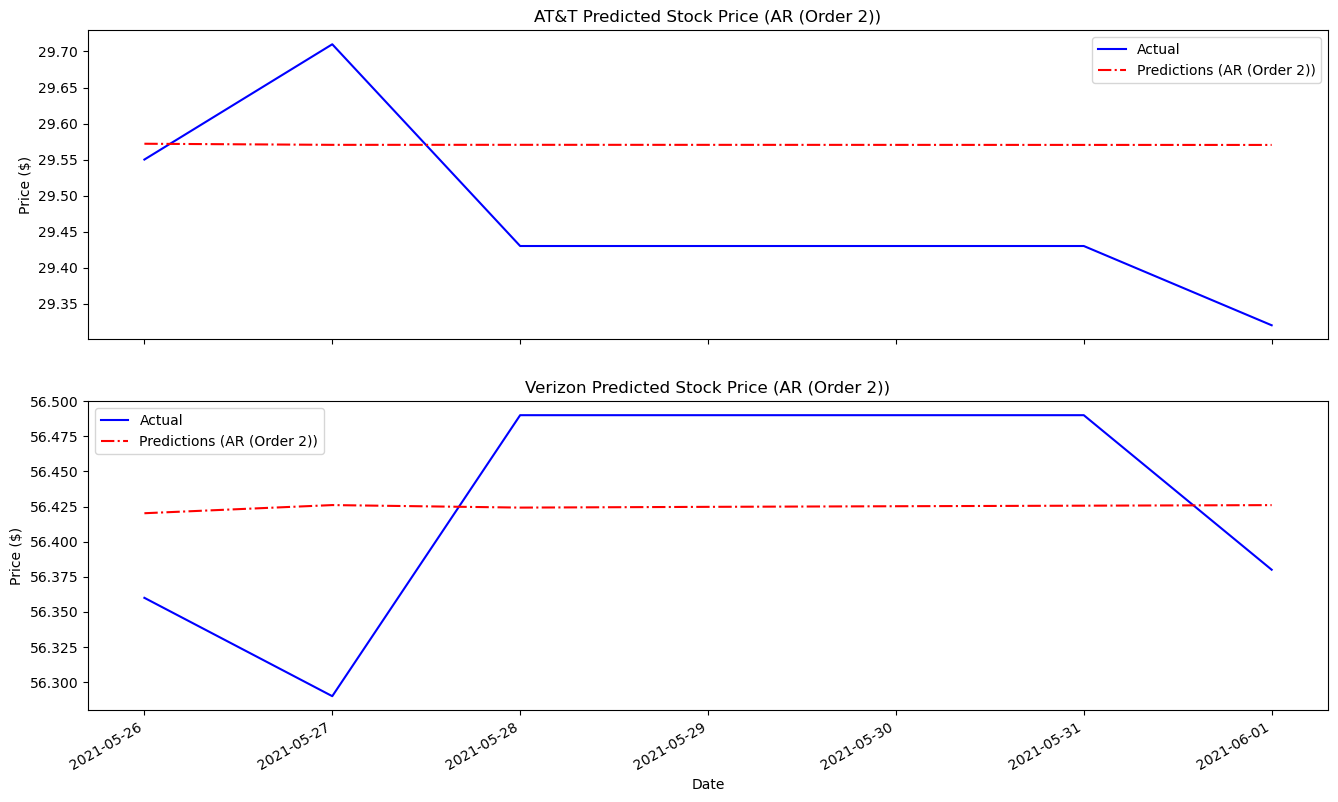

In [44]:
visualize_predictions(
    t_eval,
    ar_predictions_ord2["t_inv_diff"],
    v_eval,
    ar_predictions_ord2["v_inv_diff"],
    "AR (Order 2)",
    "../images/ar_order_2_predictions.png",
)

## Forecasting with ARIMA (Autoregressive Integrated Moving Average)

We'll use the ARIMA model to forecast the differenced series. The ARIMA model is a generalization of an autoregressive moving average (ARMA) model. It has three components: autoregressive (AR), differencing (I), and moving average (MA). The ARIMA model is suitable for non-stationary data.


In [45]:
v_arima_train.describe()

count        875.0
mean     57.785394
std       2.077066
min          49.94
25%          56.53
50%          57.89
75%         59.385
max          62.07
Name: close_v, dtype: Float64

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import numpy as np


def cross_val_score(
    endog,
    order: Tuple[int, int],
    d: int = 0,
    seasonal_order: Tuple[int, int, int, int] = (0, 0, 0, 0),
    cv_splits: int = 5,
    **model_kwargs,
) -> float:
    """
    Generalized cross-validation score for ARIMA/SARIMA models.

    Args:
        endog (array-like): The time series data.
        order (Tuple[int, int]): A tuple (p, q) for the AR and MA orders.
        d (int): The degree of non-seasonal differencing.
        seasonal_order (Tuple[int, int, int, int]): Seasonal order tuple (P, D, Q, s).
            For non-seasonal models, leave as (0, 0, 0, 0).
        cv_splits (int): Number of cross-validation splits.
        model_kwargs: Additional keyword arguments to pass to SARIMAX.

    Returns:
        float: The average RMSE across the CV folds.
    """
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    errors = []

    for train_index, test_index in tscv.split(endog):
        train, test = endog[train_index], endog[test_index]
        try:
            # Build the SARIMAX model; note that if seasonal_order is (0,0,0,0),
            # the model is effectively non-seasonal.
            model = SARIMAX(
                train,
                order=(order[0], d, order[1]),
                seasonal_order=seasonal_order,
                simple_differencing=False,
                **model_kwargs,
            )
            model_fit = model.fit(disp=False)
            # Forecast the length of the test set
            forecast = model_fit.forecast(steps=len(test))
            rmse = np.sqrt(np.mean((forecast - test) ** 2))
            errors.append(rmse)
        except Exception as e:
            print(
                f"Cross-validation failed for order {order} with seasonal_order {seasonal_order}: {e}"
            )
            errors.append(np.inf)  # Penalize failing configurations

    return np.mean(errors)

In [47]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
from typing import List, Tuple, Union


def optimize_ARIMA(
    endog: Union[pd.Series, List[float]],
    order_list: List[Tuple[int, int]],
    d: int,
    use_cv: bool = False,
    cv_splits: int = 5,
) -> pd.DataFrame:
    """
    Optimize ARIMA model parameters by selecting the best (p, q) order based on either AIC or
    cross-validation RMSE. For ARIMA, the seasonal component is set to (0, 0, 0, 0).

    Args:
        endog: Time series data.
        order_list: List of (p, q) orders to evaluate.
        d: Degree of differencing.
        use_cv: If True, use cross-validation RMSE as the performance metric instead of AIC.
        cv_splits: Number of splits for cross-validation.

    Returns:
        pd.DataFrame: DataFrame with candidate orders and their corresponding AIC or CV_RMSE,
                      sorted in ascending order.
    """

    def fit_order(order: Tuple[int, int]) -> Union[List, None]:
        try:
            if use_cv:
                # For ARIMA, use seasonal_order (0, 0, 0, 0)
                cv_score = cross_val_score(endog, order, d, (0, 0, 0, 0), cv_splits)
                return [order, cv_score]
            else:
                model = SARIMAX(
                    endog,
                    order=(order[0], d, order[1]),
                    seasonal_order=(0, 0, 0, 0),
                    simple_differencing=False,
                ).fit(disp=False)
                aic = model.aic
                return [order, aic]
        except Exception as e:
            print(f"Failed for order {order}: {e}")
            return None

    results = []
    for order in tqdm(order_list, desc="Optimizing ARIMA"):
        res = fit_order(order)
        if res is not None:
            results.append(res)

    if not results:
        raise ValueError("No models were successfully fitted.")

    metric_name = "CV_RMSE" if use_cv else "AIC"
    result_df = pd.DataFrame(results, columns=["(p,q)", metric_name])
    result_df = result_df.sort_values(by=metric_name, ascending=True).reset_index(
        drop=True
    )
    return result_df

In [48]:
# Define the p and q parameters to take any value between 0 and 10.
from itertools import product

ps = range(0, 3, 1)
qs = range(0, 3, 1)
d = 1
order_list = list(product(ps, qs))

In [49]:
t_result_df = optimize_ARIMA(t_arima_train, order_list, d, use_cv=True, cv_splits=5)
v_result_df = optimize_ARIMA(v_arima_train, order_list, d, use_cv=True, cv_splits=5)

Optimizing ARIMA:   0%|          | 0/9 [00:00<?, ?it/s]/var/folders/1x/lvmnv0vn3j3g994_j19pll480000gn/T/ipykernel_34681/760411314.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = endog[train_index], endog[test_index]
/var/folders/1x/lvmnv0vn3j3g994_j19pll480000gn/T/ipykernel_34681/760411314.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = endog[train_index], endog[test_index]
/var/folders/1x/lvmnv0vn3j3g994_j19pll480000gn/T/ipykernel_34681/760411314.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tr

In [50]:
print(f"Best p, q parameters for AT&T: {t_result_df['(p,q)'].iloc[0]}.")
print(f"Best p, q parameters for Verizon: {v_result_df['(p,q)'].iloc[0]}.")

Best p, q parameters for AT&T: (0, 0).
Best p, q parameters for Verizon: (1, 2).


In [51]:
t_result_df

,"(p,q)",CV_RMSE
0,"(0, 0)",2.278230
1,"(2, 2)",2.313194
2,"(2, 0)",2.314551
3,"(1, 2)",2.320188
4,"(0, 2)",2.320237
5,"(1, 0)",2.321137
6,"(0, 1)",2.326745
7,"(1, 1)",2.327945
8,"(2, 1)",2.335314


In [52]:
t_model = ARIMA(t_arima_train, order=(2, 1, 2))
v_model = ARIMA(v_arima_train, order=(2, 1, 1))
t_model_fit = t_model.fit(method_kwargs={"maxiter": 500})
v_model_fit = v_model.fit(method_kwargs={"maxiter": 500})

In [53]:
print(f"AT&T Model Summary:\n {t_model_fit.summary()}\n")
print(f"Verizon Model Summary:\n{v_model_fit.summary()}")

AT&T Model Summary:
                                SARIMAX Results                                
Dep. Variable:                close_t   No. Observations:                  875
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -538.011
Date:                Thu, 08 May 2025   AIC                           1086.022
Time:                        14:30:02   BIC                           1109.887
Sample:                    01-02-2019   HQIC                          1095.151
                         - 05-25-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8561      0.016   -113.476      0.000      -1.888      -1.824
ar.L2         -0.9549      0.017    -57.790      0.000      -0.987      -0.922
ma.L1          1.7966      0.02

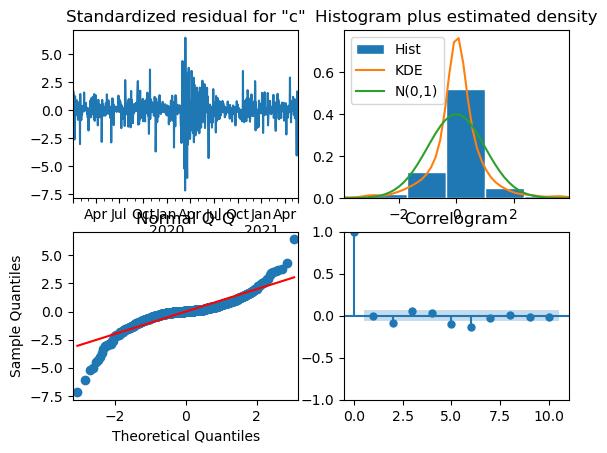

In [54]:
t_model_fit.plot_diagnostics()
plt.show()

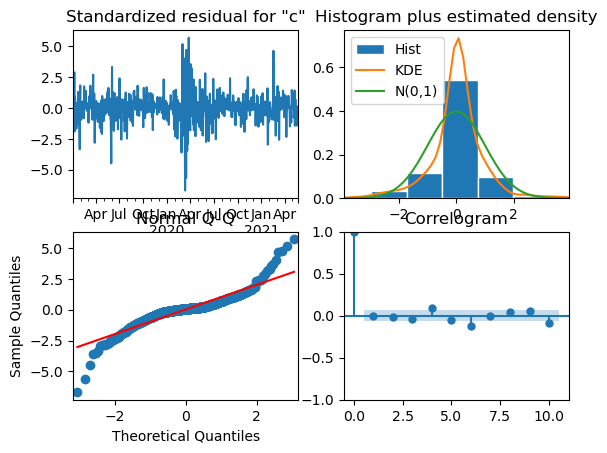

In [55]:
v_model_fit.plot_diagnostics()
plt.show()

In [56]:
# Check the residuals using the Ljung-Box test.
# If p-values < 0.05, the residuals are not white noise.
from statsmodels.stats.diagnostic import acorr_ljungbox

t_residuals = t_model_fit.resid
v_residuals = v_model_fit.resid

print(
    f"AT&T Ljung-Box analysis, first 10 residuals:\n {acorr_ljungbox(t_residuals, lags=np.arange(1,11,1).tolist(), return_df=True)}"
)
print(
    f"Verizon Ljung-Box analysis, first 10 residuals:\n {acorr_ljungbox(v_residuals, lags=np.arange(1,11,1).tolist(), return_df=True)}"
)

AT&T Ljung-Box analysis, first 10 residuals:
      lb_stat  lb_pvalue
1   0.001465   0.969470
2   0.054616   0.973061
3   0.147821   0.985537
4   0.166230   0.996732
5   0.166289   0.999435
6   0.264010   0.999653
7   1.537734   0.980974
8   1.591416   0.991084
9   1.758295   0.994739
10  1.767084   0.997834
Verizon Ljung-Box analysis, first 10 residuals:
      lb_stat  lb_pvalue
1   0.007501   0.930983
2   0.008548   0.995735
3   0.017547   0.999385
4   0.079662   0.999227
5   0.080473   0.999905
6   0.339152   0.999284
7   0.649490   0.998694
8   0.750076   0.999388
9   0.904518   0.999628
10  0.936441   0.999873


In [57]:
t_arima = t_model_fit.get_forecast(steps=len(t_arima_test)).predicted_mean
v_arima = v_model_fit.get_forecast(steps=len(v_arima_test)).predicted_mean

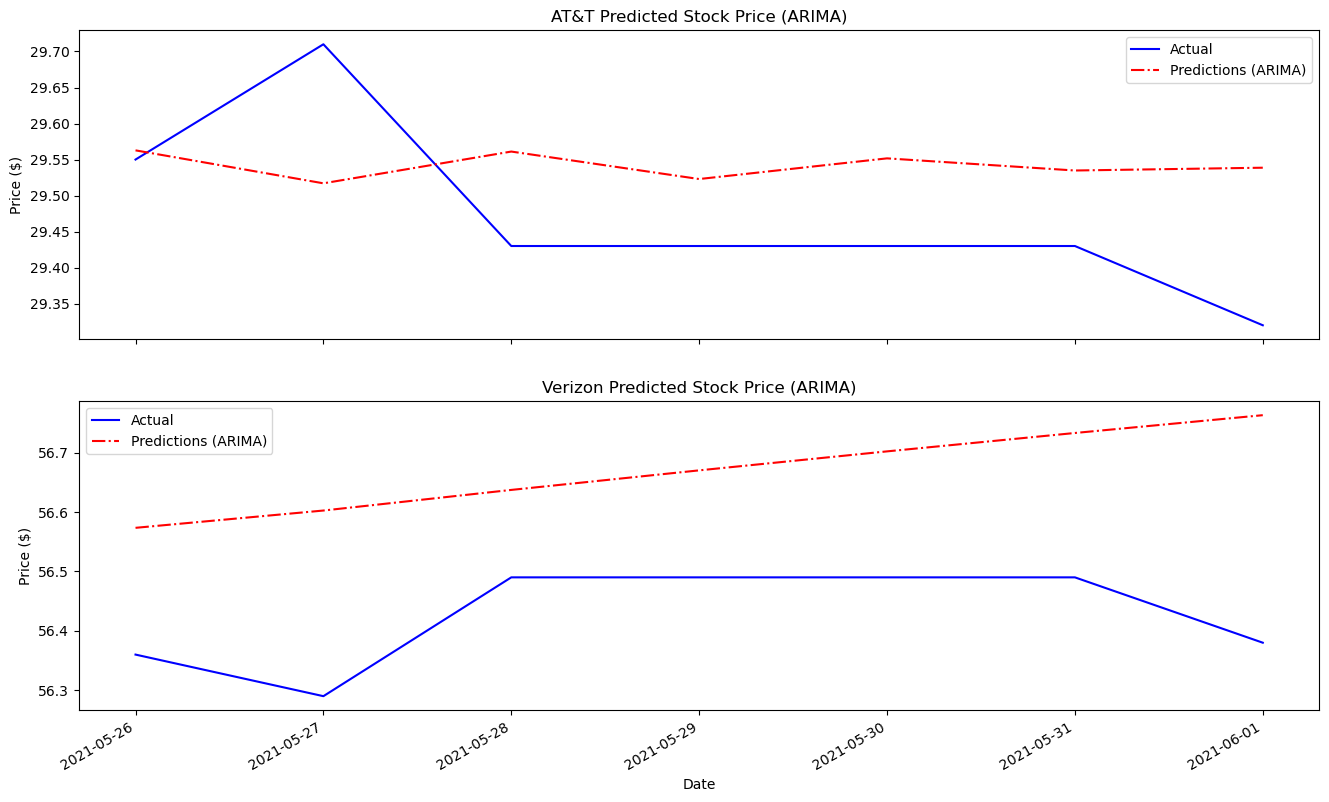

In [58]:
visualize_predictions(
    t_arima_test,
    t_arima,
    v_arima_test,
    v_arima,
    "ARIMA",
    "../images/arima_predictions.png",
)

In [59]:
t_arima_rmse, t_arima_mae, t_arima_mape = evaluate_forecast(t_eval, t_arima)
v_arima_rmse, v_arima_mae, v_arima_mape = evaluate_forecast(v_eval, v_arima)

print(
    f"AT&T ARIMA - RMSE: {t_arima_rmse:.4f}, MAE: {t_arima_mae:.4f}, MAPE: {t_arima_mape:.2f}%"
)
print(
    f"Verizon ARIMA - RMSE: {v_arima_rmse:.4f}, MAE: {v_arima_mae:.4f}, MAPE: {v_arima_mape:.2f}%"
)

AT&T ARIMA - RMSE: 0.1398, MAE: 0.1250, MAPE: 0.42%
Verizon ARIMA - RMSE: 0.2530, MAE: 0.2416, MAPE: 0.43%


## Forecasting with SARIMA (Seasonal ARIMA)

`SARIMAX` models are `Seasonal AutoRegressive Integrated Moving Average` models. They are a generalization of the `ARIMA` models that include seasonality, which should be helpful due to the previously-observed seven-day trends in the data. The workflow for SARIMA models is the same as for ARIMA models, but with an additional step to identify the seasonal order `(P, D, Q, s)`. One does the non-seasonal difference `d` first, then the seasonal difference `D`. Then one plots the ACF and PACF to determine the seasonal order `(P, Q)`. Let's look at using `SARIMA` models to forecast the time series data.


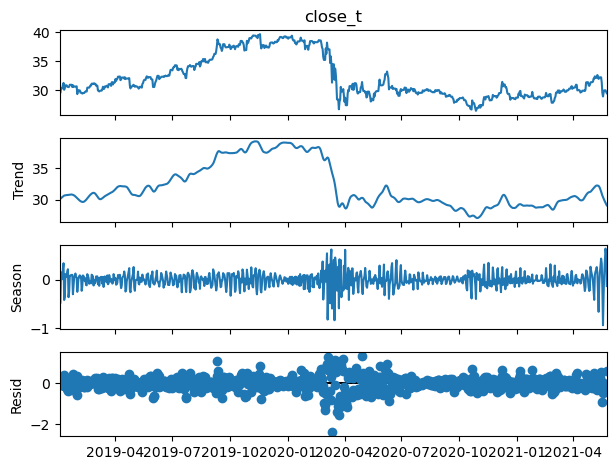

In [60]:
# Perform STL decomposition on the AT&T dataset
from statsmodels.tsa.seasonal import STL

t_stl = STL(t_arima_train, period=7)
t_stl = t_stl.fit()

# Plot the decomposition
t_stl.plot()
plt.show()

<Axes: xlabel='timestamp'>

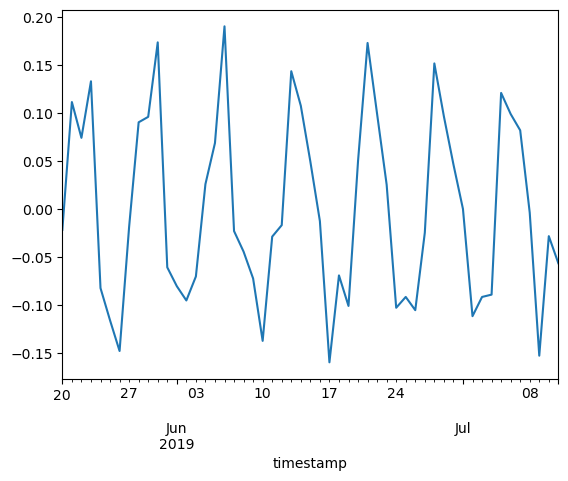

In [61]:
t_stl.seasonal["2019-05-20":"2019-07-11"].plot()

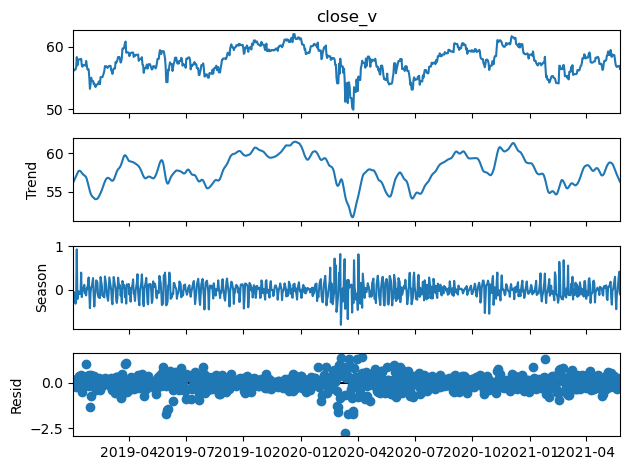

In [62]:
# Perform STL decomposition on the Verizon dataset
v_stl = STL(v_arima_train, period=7)
v_stl = v_stl.fit()

# Plot the decomposition
v_stl.plot()
plt.show()

<Axes: xlabel='timestamp'>

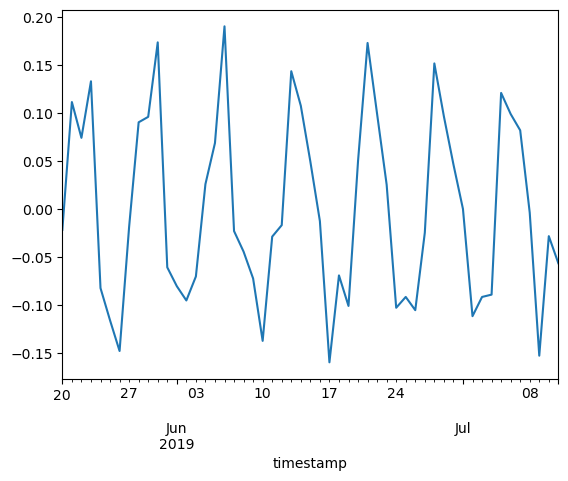

In [63]:
t_stl.seasonal["2019-05-20":"2019-07-11"].plot()

In [64]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm
from typing import List, Tuple, Union


def optimize_SARIMA(
    endog: Union[pd.Series, List[float]],
    order_list: List[Tuple[int, int, int, int]],
    d: int,
    D: int,
    s: int,
    use_cv: bool = False,  # Toggle between AIC and cross-validation
    cv_splits: int = 5,
) -> pd.DataFrame:
    """
    Optimize SARIMA model parameters using either AIC or cross-validation error.
    """

    def fit_order(order: Tuple[int, int, int, int]) -> Union[List, None]:
        try:
            if use_cv:
                # Split order into non-seasonal and seasonal parts
                non_seasonal_order = (order[0], order[1])
                seasonal_order = (order[2], D, order[3], s)
                cv_error = cross_val_score(
                    endog, non_seasonal_order, d, seasonal_order, cv_splits
                )
                return [order, cv_error]
            else:
                model = SARIMAX(
                    endog,
                    order=(order[0], d, order[1]),
                    seasonal_order=(order[2], D, order[3], s),
                    simple_differencing=False,
                ).fit(disp=False)
                aic = model.aic
                return [order, aic]
        except Exception as e:
            print(f"Failed for order {order}: {e}")
            return None

    results = []
    for order in tqdm(order_list, desc="Optimizing SARIMA", leave=True):
        res = fit_order(order)
        if res is not None:
            results.append(res)

    if not results:
        raise ValueError("No models were successfully fitted.")

    metric_name = "CV_RMSE" if use_cv else "AIC"
    result_df = pd.DataFrame(results, columns=["(p,q,P,Q)", metric_name])
    result_df = result_df.sort_values(by=metric_name, ascending=True).reset_index(
        drop=True
    )
    return result_df

In [65]:
# Define the SARIMA parameters
ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)

d = 1
D = 1
s = 7

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [66]:
t_sarima_params_df = optimize_SARIMA(
    t_arima_train, SARIMA_order_list, d, D, s, use_cv=True, cv_splits=5
)
v_sarima_params_df = optimize_SARIMA(
    v_arima_train, SARIMA_order_list, d, D, s, use_cv=True, cv_splits=5
)
print(f"Best AT&T SARIMA parameters: {t_sarima_params_df['(p,q,P,Q)'].iloc[0]}.")
print(f"Best Verizon SARIMA parameters: {v_sarima_params_df['(p,q,P,Q)'].iloc[0]}.")

Optimizing SARIMA:   0%|          | 0/81 [00:00<?, ?it/s]

/var/folders/1x/lvmnv0vn3j3g994_j19pll480000gn/T/ipykernel_34681/760411314.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = endog[train_index], endog[test_index]
/var/folders/1x/lvmnv0vn3j3g994_j19pll480000gn/T/ipykernel_34681/760411314.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = endog[train_index], endog[test_index]
/var/folders/1x/lvmnv0vn3j3g994_j19pll480000gn/T/ipykernel_34681/760411314.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

Optimizing SARIMA:   0%|          | 0/81 [00:00<?, ?it/s]

/var/folders/1x/lvmnv0vn3j3g994_j19pll480000gn/T/ipykernel_34681/760411314.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = endog[train_index], endog[test_index]
/var/folders/1x/lvmnv0vn3j3g994_j19pll480000gn/T/ipykernel_34681/760411314.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = endog[train_index], endog[test_index]
/var/folders/1x/lvmnv0vn3j3g994_j19pll480000gn/T/ipykernel_34681/760411314.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

Best AT&T SARIMA parameters: (2, 1, 0, 1).
Best Verizon SARIMA parameters: (2, 2, 1, 1).


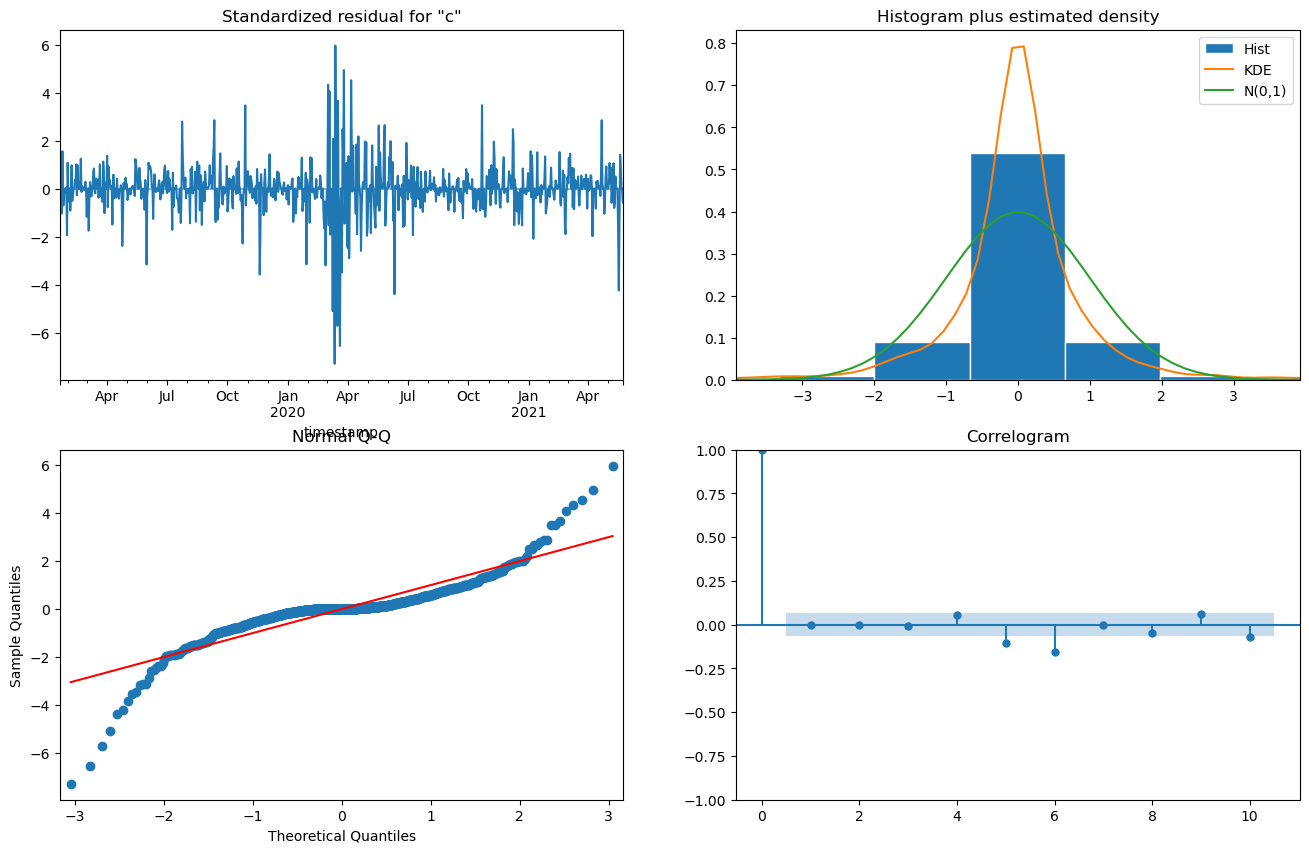

In [67]:
# Assign the best parameters from the optimization function
best_order_t = t_sarima_params_df["(p,q,P,Q)"].iloc[0]
best_p, best_q, best_P, best_Q = best_order_t
D = 1
s = 7

# Train the SARIMA model with D=1
t_SARIMA_model = SARIMAX(
    t_arima_train,
    order=(best_p, d, best_q),
    seasonal_order=(best_P, D, best_Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
t_SARIMA_model_fit = t_SARIMA_model.fit(disp=False)

# Diagnostic Plots
t_SARIMA_model_fit.plot_diagnostics(figsize=(16, 10))
plt.show()

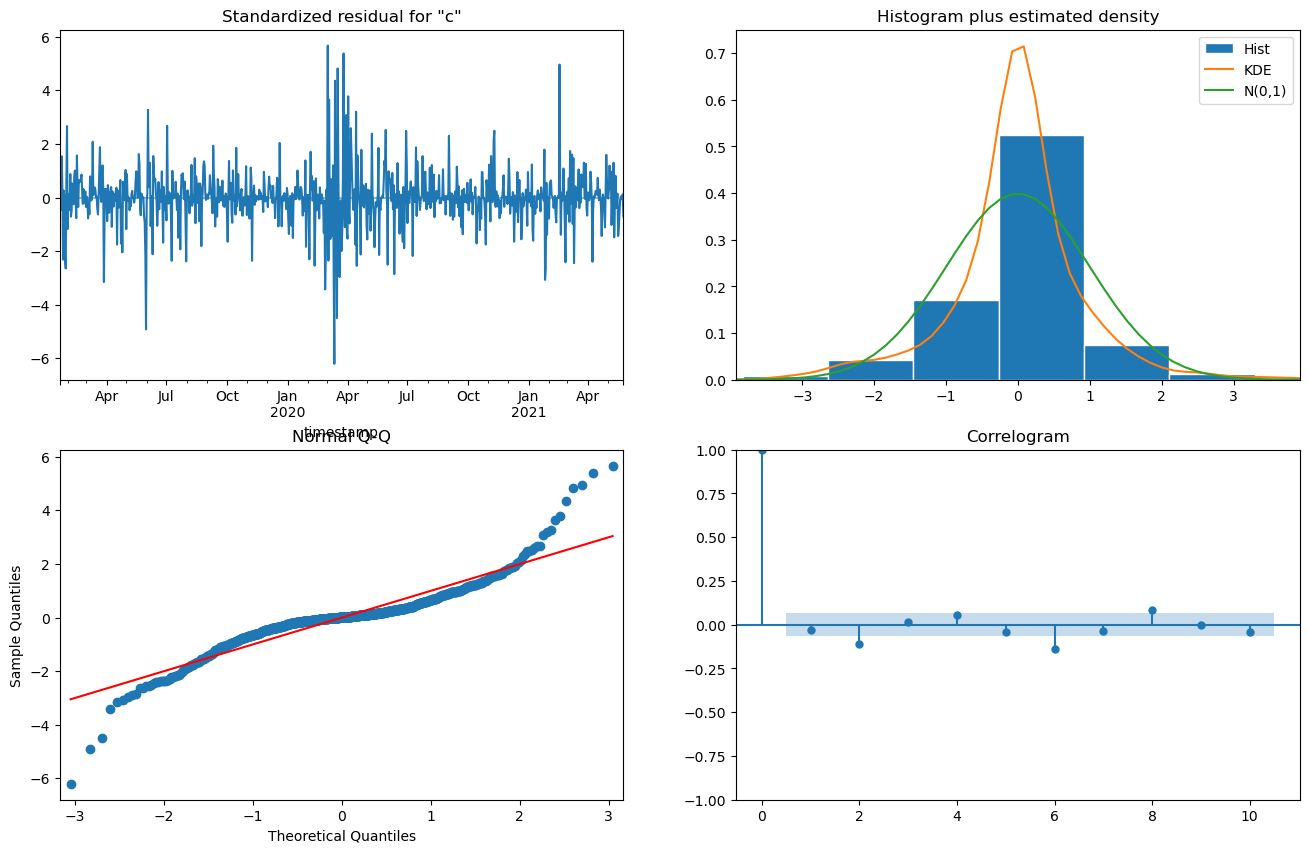

In [68]:
# Assign the best parameters from the optimization function
best_order_v = v_sarima_params_df["(p,q,P,Q)"].iloc[0]
best_p, best_q, best_P, best_Q = best_order_v
D = 1
s = 7

# Train the SARIMA model with D=1
v_SARIMA_model = SARIMAX(
    v_arima_train,
    order=(best_p, d, best_q),
    seasonal_order=(best_P, D, best_Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
v_SARIMA_model_fit = v_SARIMA_model.fit(disp=False)

# Diagnostic Plots
v_SARIMA_model_fit.plot_diagnostics(figsize=(16, 10))
plt.show()

In [69]:
# Check the residuals using the Ljung-Box test.
# If p-values < 0.05, the residuals are not white noise.
t_sarima_residuals = t_SARIMA_model_fit.resid
v_sarima_residuals = v_SARIMA_model_fit.resid

print(
    f"AT&T Ljung-Box analysis, first 10 residuals:\n {acorr_ljungbox(t_sarima_residuals, lags=np.arange(1,15,1).tolist(), return_df=True)}"
)
print(
    f"Verizon Ljung-Box analysis, first 10 residuals:\n {acorr_ljungbox(v_sarima_residuals, lags=np.arange(1,15,1).tolist(), return_df=True)}"
)

AT&T Ljung-Box analysis, first 10 residuals:
        lb_stat     lb_pvalue
1     0.205627  6.502168e-01
2     0.239969  8.869343e-01
3     0.240133  9.708643e-01
4     0.281521  9.909756e-01
5     0.281619  9.979746e-01
6     0.286350  9.995605e-01
7   162.147873  1.132648e-31
8   162.173754  5.614119e-31
9   162.210622  2.578406e-30
10  162.275524  1.098172e-29
11  162.953212  3.313631e-29
12  163.084480  1.234548e-28
13  163.148645  4.539004e-28
14  163.154230  1.645588e-27
Verizon Ljung-Box analysis, first 10 residuals:
        lb_stat     lb_pvalue
1   185.405354  3.201152e-42
2   185.688883  4.766191e-41
3   185.852400  4.802933e-40
4   186.155193  3.551400e-39
5   187.875357  1.111538e-38
6   193.252430  5.175074e-39
7   338.393451  3.755136e-69
8   453.939198  5.294932e-93
9   462.392935  6.420011e-94
10  462.409241  4.703594e-93
11  462.426456  3.258887e-92
12  462.461024  2.129908e-91
13  462.808245  1.142059e-90
14  462.993177  6.362063e-90


In [70]:
residuals = t_SARIMA_model_fit.resid
ljungbox_results = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(ljungbox_results)

       lb_stat     lb_pvalue
1     0.205627  6.502168e-01
2     0.239969  8.869343e-01
3     0.240133  9.708643e-01
4     0.281521  9.909756e-01
5     0.281619  9.979746e-01
6     0.286350  9.995605e-01
7   162.147873  1.132648e-31
8   162.173754  5.614119e-31
9   162.210622  2.578406e-30
10  162.275524  1.098172e-29


In [71]:
t_sarima = t_SARIMA_model_fit.get_forecast(steps=len(t_arima_test)).predicted_mean
v_sarima = v_SARIMA_model_fit.get_forecast(steps=len(v_arima_test)).predicted_mean

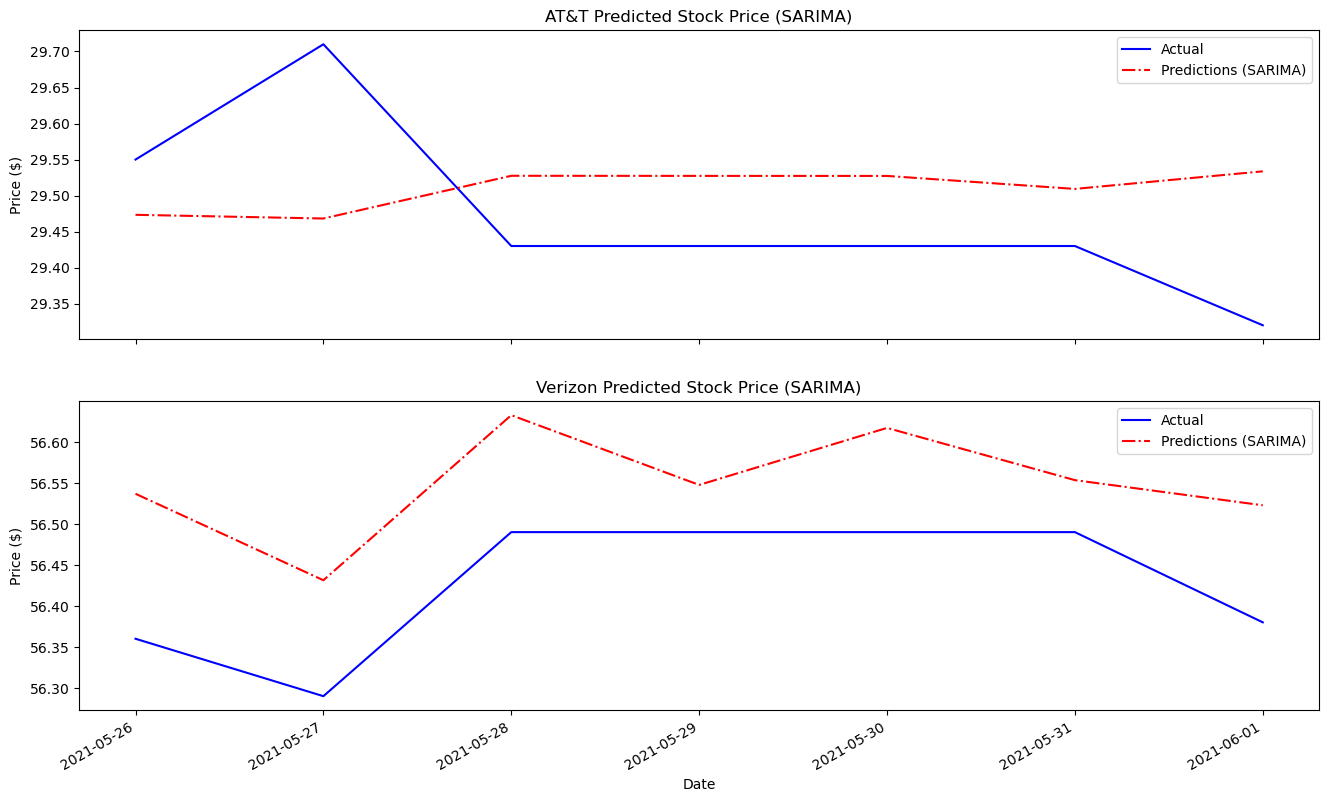

In [72]:
visualize_predictions(
    t_arima_test,
    t_sarima,
    v_arima_test,
    v_sarima,
    "SARIMA",
    "../images/sarima_predictions.png",
)

In [73]:
# The autocorrelated residuals are confounding.
# I could use Fourier terms as exogenous variables, but that may be overkill.
t_sarima_rmse, t_sarima_mae, t_sarima_mape = evaluate_forecast(t_eval, t_sarima)
v_sarima_rmse, v_sarima_mae, v_sarima_mape = evaluate_forecast(v_eval, v_sarima)

print(
    f"AT&T ARIMA - RMSE: {t_sarima_rmse:.4f}, MAE: {t_sarima_mae:.4f}, MAPE: {t_sarima_mape:.2f}%"
)
print(
    f"Verizon ARIMA - RMSE: {v_sarima_rmse:.4f}, MAE: {v_sarima_mae:.4f}, MAPE: {v_sarima_mape:.2f}%"
)

AT&T ARIMA - RMSE: 0.1438, MAE: 0.1291, MAPE: 0.44%
Verizon ARIMA - RMSE: 0.1284, MAE: 0.1216, MAPE: 0.22%


## Forecasting with `auto_arima`


In [74]:
import pmdarima as pm

## Fit auto_arima for AT&T data
auto_model_t = pm.auto_arima(
    t_arima_train,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    start_P=0,
    start_Q=0,
    max_P=3,
    max_Q=3,
    m=7,
    d=1,
    D=1,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

print(auto_model_t.summary())

/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1684.129, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1499.003, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=1686.086, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=1392.637, Time=0.12 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,0)[7]             : AIC=1345.499, Time=0.36 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=1.66 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=1351.379, Time=0.12 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(3,1,0)[7]             : AIC=1347.230, Time=0.27 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(3,1,0)[7]             : AIC=1346.949, Time=0.51 sec
 ARIMA(0,1,1)(3,1,0)[7]             : AIC=1345.857, Time=0.18 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(3,1,0)[7]             : AIC=1349.240, Time=0.68 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,0)[7] intercept   : AIC=1347.474, Time=0.54 sec

Best model:  ARIMA(1,1,0)(3,1,0)[7]          
Total fit time: 5.787 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  875
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 7)   Log Likelihood                -667.750
Date:                           Thu, 08 May 2025   AIC                           1345.499
Time:                                   14:35:33   BIC                           1369.324
Sample:                               01-02-2019   HQIC                          1354.617
                                    - 05-25-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

In [75]:
# Fit auto_arima for Verizon data
auto_model_v = pm.auto_arima(
    v_arima_train,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    start_P=0,
    start_Q=0,
    max_P=3,
    max_Q=3,
    m=7,
    d=1,
    D=1,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

print(auto_model_v.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2164.098, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1983.585, Time=0.05 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=2162.086, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=1876.347, Time=0.11 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,0)[7]             : AIC=1808.504, Time=0.19 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=2.23 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=1817.765, Time=0.12 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(3,1,0)[7]             : AIC=1810.053, Time=0.23 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(3,1,0)[7]             : AIC=inf, Time=1.53 sec
 ARIMA(0,1,1)(3,1,0)[7]             : AIC=1807.985, Time=0.18 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,0)[7]             : AIC=1875.621, Time=0.11 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(3,1,1)[7]             : AIC=inf, Time=1.77 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.09 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(3,1,0)[7]             : AIC=1809.714, Time=0.21 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(3,1,0)[7]             : AIC=1811.266, Time=0.53 sec


/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(3,1,0)[7] intercept   : AIC=1809.979, Time=0.48 sec

Best model:  ARIMA(0,1,1)(3,1,0)[7]          
Total fit time: 10.060 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  875
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 7)   Log Likelihood                -898.992
Date:                            Thu, 08 May 2025   AIC                           1807.985
Time:                                    14:35:44   BIC                           1831.810
Sample:                                01-02-2019   HQIC                          1817.103
                                     - 05-25-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

In [76]:
t_pda_order = (1, 1, 0, 3, 1, 0, 7)
v_pda_order = (0, 1, 1, 3, 1, 0, 7)
t_pdarima = auto_model_t.predict(n_periods=forecast_window)
v_pdarima = auto_model_v.predict(n_periods=forecast_window)

/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/timeseries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


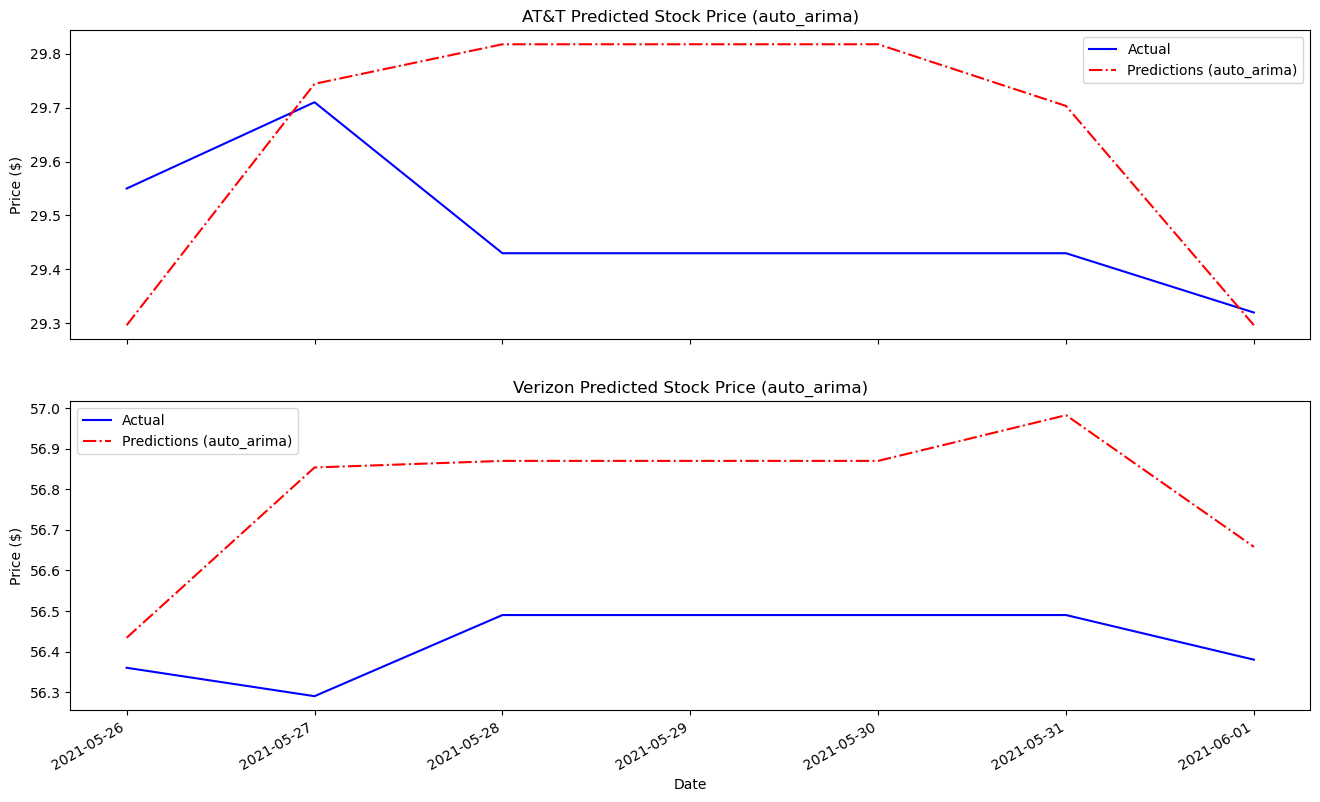

In [77]:
visualize_predictions(
    t_arima_test,
    t_pdarima,
    v_arima_test,
    v_pdarima,
    "auto_arima",
    "../images/auto_arima_predictions.png",
)

In [78]:
t_pdarima_rmse, t_pdarima_mae, t_pdarima_mape = evaluate_forecast(t_eval, t_pdarima)
v_pdarima_rmse, v_pdarima_mae, v_pdarima_mape = evaluate_forecast(v_eval, v_pdarima)

print(
    f"AT&T ARIMA - RMSE: {t_pdarima_rmse:.4f}, MAE: {t_pdarima_mae:.4f}, MAPE: {t_pdarima_mape:.2f}%"
)
print(
    f"Verizon ARIMA - RMSE: {v_pdarima_rmse:.4f}, MAE: {v_pdarima_mae:.4f}, MAPE: {v_pdarima_mape:.2f}%"
)

AT&T ARIMA - RMSE: 0.2906, MAE: 0.2496, MAPE: 0.85%
Verizon ARIMA - RMSE: 0.3922, MAE: 0.3641, MAPE: 0.65%


## Overall Evaluation Comparison

Let's use mean average percent error (MAPE) to evaluate the models. MAPE is a measure of prediction accuracy in a forecasting method. It is defined as the average of the absolute percentage errors of each forecasted value. The formula for MAPE is:

$$MAPE=100 \frac{1}{n} \sum_{t=1}^{n} \left| \frac{A_t - F_t}{A_t} \right|$$

MAPE is a good measure of accuracy because of its intuitiveness and ease of interpretation: it is expressed as a percentage, so it is easy to understand and communicate. It is also scale-independent, meaning that it can be used to compare the accuracy of forecasts across different time series with different units of measurement. However, MAPE has some limitations. It can be sensitive to small denominators, which can lead to large percentage errors. It also assumes that the forecast errors are symmetrically distributed, which may not always be the case.


In [79]:
# Create a DataFrame of the results
mape_results_df = pd.DataFrame(
    {
        "Model": [
            "Mean",
            "Naive",
            "MA",
            "AR",
            "ARIMA",
            "SARIMA",
            "auto_arima",
        ],
        "AT&T": [
            t_mean_mape,
            t_naive_mape,
            t_ma_mape,
            t_ar_mape,
            t_arima_mape,
            t_sarima_mape,
            t_pdarima_mape,
        ],
        "Verizon": [
            v_mean_mape,
            v_naive_mape,
            v_ma_mape,
            v_ar_mape,
            v_arima_mape,
            v_sarima_mape,
            v_pdarima_mape,
        ],
    }
)
mape_results_df

,Model,AT&T,Verizon
0,Mean,0.779221,0.731340
1,Naive,1.403523,0.730757
2,MA,0.479056,0.127364
3,AR,1.023519,0.231661
4,ARIMA,0.424194,0.428281
5,SARIMA,0.437689,0.215594
6,auto_arima,0.847380,0.645300


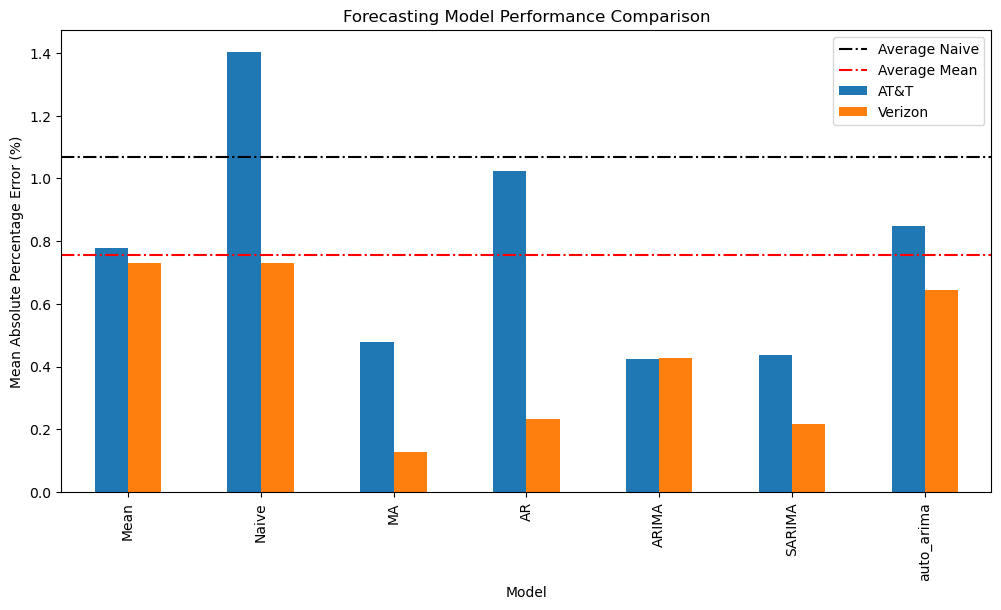

In [80]:
ax = mape_results_df.set_index("Model").plot(kind="bar", figsize=(12, 6))
ax.set_ylabel("Mean Absolute Percentage Error (%)")
ax.set_title("Forecasting Model Performance Comparison")
ax.axhline(
    y=(t_naive_mape + v_naive_mape) / 2,
    color="k",
    linestyle="-.",
    label="Average Naive",
)
ax.axhline(
    y=(t_mean_mape + v_mean_mape) / 2,
    color="r",
    linestyle="-.",
    label="Average Mean",
)
ax.legend()
plt.savefig("../images/model_comparison.png", bbox_inches="tight")

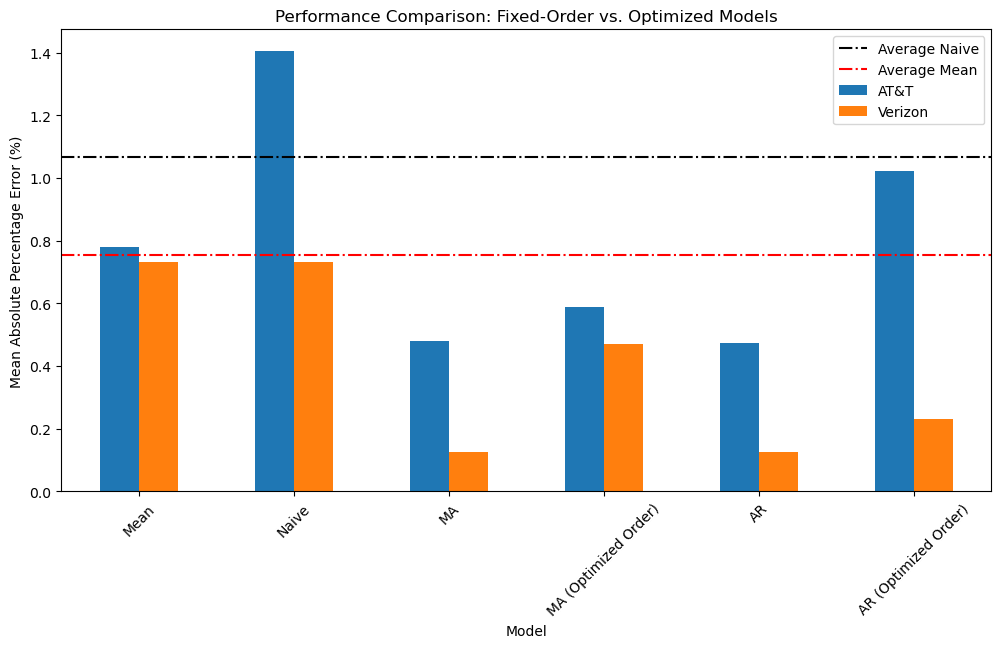

In [81]:
# Create a DataFrame of the MA and AR results: fixed-order vs. optimized
mape_order_results_df = pd.DataFrame(
    {
        "Model": [
            "Mean",
            "Naive",
            "MA",
            "MA (Optimized Order)",
            "AR",
            "AR (Optimized Order)",
        ],
        "AT&T": [
            t_mean_mape,
            t_naive_mape,
            t_ma_mape,
            t_ma_opt_mape,
            t_ar_ord2_mape,
            t_ar_mape,
        ],
        "Verizon": [
            v_mean_mape,
            v_naive_mape,
            v_ma_mape,
            v_ma_opt_mape,
            v_ar_ord2_mape,
            v_ar_mape,
        ],
    }
)

ax = mape_order_results_df.set_index("Model").plot(kind="bar", figsize=(12, 6))
ax.axhline(
    y=(t_naive_mape + v_naive_mape) / 2,
    color="k",
    linestyle="-.",
    label="Average Naive",
)
ax.axhline(
    y=(t_mean_mape + v_mean_mape) / 2,
    color="r",
    linestyle="-.",
    label="Average Mean",
)
ax.set_ylabel("Mean Absolute Percentage Error (%)")
ax.set_title("Performance Comparison: Fixed-Order vs. Optimized Models")
ax.legend()
plt.xticks(rotation=45)
plt.savefig("../images/model_order_comparison.png", bbox_inches="tight")

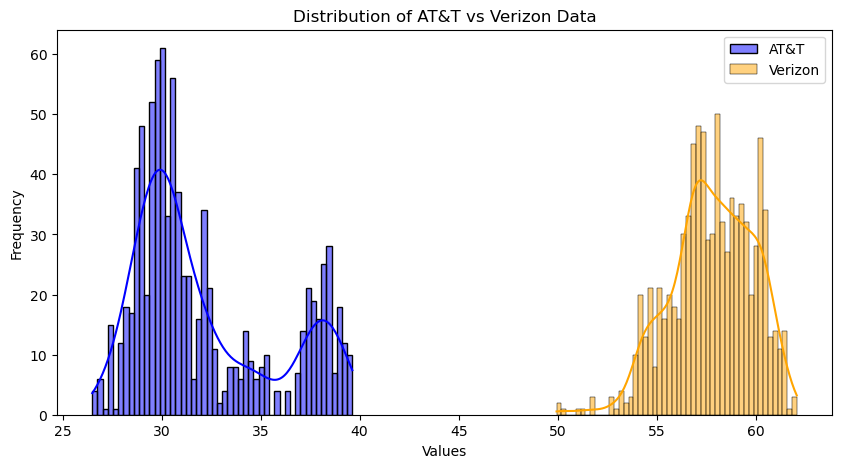

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming att_data and vz_data are Pandas Series containing the datasets
plt.figure(figsize=(10, 5))
sns.histplot(t_arima_train, kde=True, bins=50, color="blue", label="AT&T", alpha=0.5)
sns.histplot(
    v_arima_train, kde=True, bins=50, color="orange", label="Verizon", alpha=0.5
)
plt.legend()
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Distribution of AT&T vs Verizon Data")
plt.show()

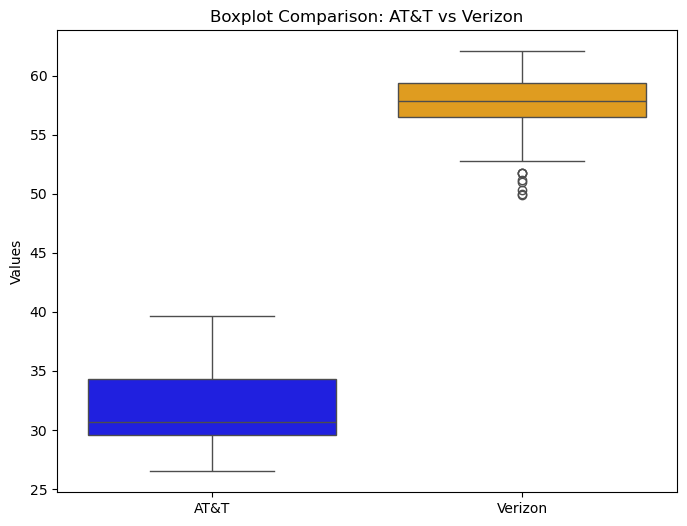

In [84]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=[t_arima_train, v_arima_train], palette=["blue", "orange"])
plt.xticks([0, 1], ["AT&T", "Verizon"])
plt.ylabel("Values")
plt.title("Boxplot Comparison: AT&T vs Verizon")
plt.show()

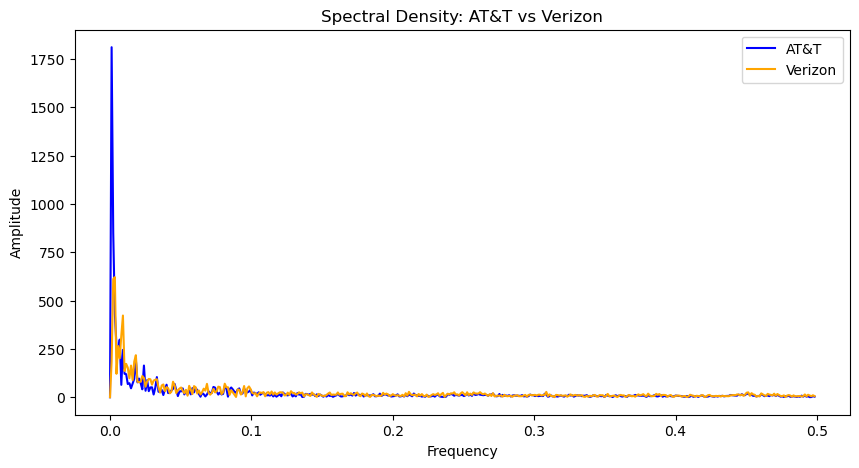

In [85]:
import numpy as np

# Convert series to numpy arrays
att_fft = np.fft.fft(t_arima_train - np.mean(t_arima_train))
vz_fft = np.fft.fft(v_arima_train - np.mean(v_arima_train))

freqs = np.fft.fftfreq(len(t_arima_train))

plt.figure(figsize=(10, 5))
plt.plot(
    freqs[: len(freqs) // 2],
    np.abs(att_fft)[: len(freqs) // 2],
    label="AT&T",
    color="blue",
)
plt.plot(
    freqs[: len(freqs) // 2],
    np.abs(vz_fft)[: len(freqs) // 2],
    label="Verizon",
    color="orange",
)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Spectral Density: AT&T vs Verizon")
plt.legend()
plt.show()